## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y),
        p[1]*y[0]*y[2]/sum(y) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [4]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [5]:
additional_times = [33,35,56,60,68, 75,83,86,87,89,90,91,92]
additional_cumdata = [28,36,169,314,513, 716,1174,1644,1797,2194,2437,2686,2936]

# times = times + additional_times
# cumdata = np.concatenate([cumdata,additional_cumdata])
times = np.array(additional_times)
cumdata = np.array(additional_cumdata)

Text(0.5, 0, 'Days after 28 August 2019')

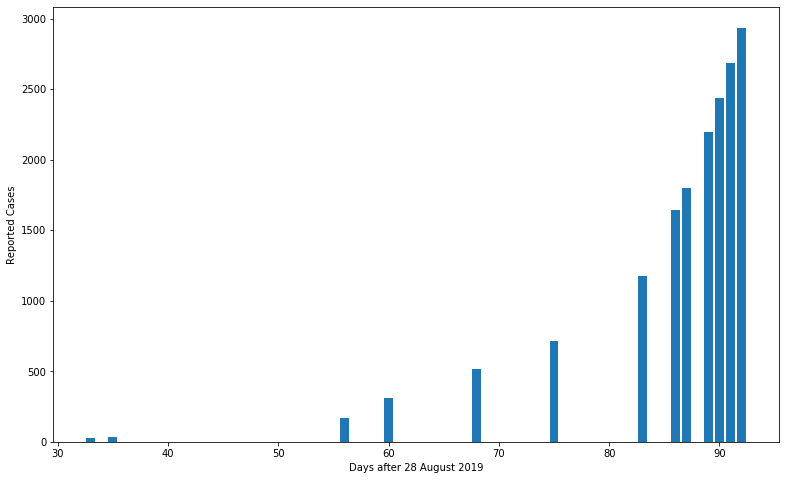

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1.5, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 4,
        "parameters": 3
    },
    "time_span": [times[0], times[-1]],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*4,
        times
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(4)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*4) + [0]*len(config['regularisation_value'])
alpha = 5e2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9600
Number of nonzeros in Lagrangian Hessian.............:     4901

Total number of variables............................:       99
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

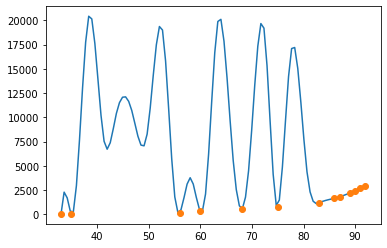

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [13]:
prange = np.logspace(-6, 6, num=80)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 150000
    }
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9600
Number of nonzeros in Lagrangian Hessian.............:     4901

Total number of variables............................:       99
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      400
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  34  4.2467764e+03 0.00e+00 2.85e+01  -5.7 1.84e+04 -10.9 5.55e-02 6.58e-03f  1
  35  4.2466247e+03 0.00e+00 2.55e+01  -5.7 1.17e+04 -11.4 1.55e-01 1.11e-01f  1
  36  4.2465617e+03 0.00e+00 2.42e+01  -5.7 2.07e+04 -11.8 6.99e-02 5.19e-02f  1
  37  4.2464232e+03 0.00e+00 2.11e+01  -5.7 1.41e+04 -11.4 4.46e-01 1.34e-01f  1
  38  4.2459831e+03 0.00e+00 9.08e+00  -5.7 1.78e+04 -11.9 3.22e-01 7.25e-01f  1
  39  4.2459017e+03 0.00e+00 9.17e-01  -5.7 8.36e+03 -12.4 3.82e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.2459008e+03 0.00e+00 2.01e-02  -5.7 7.07e+02 -12.8 1.46e-01 1.00e+00f  1
  41  4.2459008e+03 0.00e+00 7.45e-02  -5.7 2.41e+04    -  4.37e-01 1.00e+00f  1
  42  4.2459008e+03 0.00e+00 1.94e-03  -5.7 1.69e+03    -  1.00e+00 1.00e+00h  1
  43  4.2459008e+03 0.00e+00 2.57e-04  -5.7 2.82e+03    -  1.00e+00 1.00e+00f  1
  44  4.2459008e+03 0.00e+00 6.29e-06  -5.7 2.29e+02    -  1.00e+00 1.00e+00h  1
  45  4.2459008e+03 0.00e+00

  33  4.2459047e+03 0.00e+00 6.83e-02  -8.6 2.45e+04    -  7.89e-01 6.69e-01f  1
  34  4.2459047e+03 0.00e+00 2.41e-01  -8.6 8.69e+04    -  4.42e-01 2.39e-01f  2
  35  4.2459046e+03 0.00e+00 7.00e-02  -8.6 2.95e+03    -  9.75e-01 8.70e-01f  1
  36  4.2459046e+03 0.00e+00 1.79e-01  -8.6 1.00e+05    -  2.39e-01 9.30e-02f  2
  37  4.2459046e+03 0.00e+00 5.94e-02  -8.6 1.46e+03    -  7.91e-01 1.00e+00f  1
  38  4.2459045e+03 0.00e+00 2.51e-03  -8.6 2.34e+02 -12.1 1.00e+00 1.00e+00h  1
  39  4.2459045e+03 0.00e+00 1.67e-03  -8.6 5.58e+02 -12.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.2459045e+03 0.00e+00 2.88e-02  -8.6 2.14e+03 -13.1 1.00e+00 1.00e+00f  1
  41  4.2459044e+03 0.00e+00 9.03e-02  -8.6 6.76e+03 -13.5 1.00e+00 5.00e-01f  2
  42  4.2459044e+03 0.00e+00 1.74e-02  -8.6 5.19e+02    -  1.00e+00 1.00e+00f  1
  43  4.2459044e+03 0.00e+00 5.94e-02  -8.6 5.27e+03    -  8.32e-01 3.56e-01f  2
  44  4.2459043e+03 0.00e+00

  47  4.2459103e+03 0.00e+00 2.25e-01  -5.7 1.18e+04 -15.1 1.00e+00 1.00e+00h  1
  48  4.2459102e+03 0.00e+00 1.18e-02  -5.7 5.68e+02    -  1.00e+00 1.00e+00f  1
  49  4.2459102e+03 0.00e+00 2.07e-02  -5.7 2.33e+03 -13.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2459101e+03 0.00e+00 5.90e-02  -5.7 1.16e+04 -14.3 1.00e+00 2.50e-01f  3
  51  4.2459101e+03 0.00e+00 1.06e-01  -5.7 3.77e+03    -  1.00e+00 1.00e+00f  1
  52  4.2459100e+03 0.00e+00 2.37e-02  -5.7 8.34e+02    -  1.00e+00 1.00e+00f  1
  53  4.2459100e+03 0.00e+00 5.94e-02  -5.7 1.13e+04    -  7.77e-01 1.53e-01f  3
  54  4.2459099e+03 0.00e+00 2.08e-02  -5.7 7.18e+02    -  1.00e+00 1.00e+00f  1
  55  4.2459099e+03 0.00e+00 3.39e-02  -5.7 1.94e+03    -  1.00e+00 5.00e-01f  2
  56  4.2459098e+03 0.00e+00 1.02e-02  -5.7 4.07e+02    -  1.00e+00 1.00e+00f  1
  57  4.2459098e+03 0.00e+00 1.42e-02  -5.7 5.84e+02    -  1.00e+00 1.00e+00h  1
  58  4.2459098e+03 0.00e+00

  43  4.2459183e+03 0.00e+00 4.04e-02  -8.6 7.29e+03 -14.5 1.00e+00 1.00e+00f  1
  44  4.2459183e+03 0.00e+00 2.32e-01  -8.6 6.86e+04 -15.0 9.37e-01 2.17e-01f  2
  45  4.2459183e+03 0.00e+00 4.61e-01  -8.6 6.17e+04    -  1.00e+00 2.57e-01f  2
  46  4.2459181e+03 0.00e+00 3.36e-02  -8.6 1.25e+03    -  1.00e+00 9.39e-01f  1
  47  4.2459181e+03 0.00e+00 3.13e-01  -8.6 2.13e+04 -13.6 1.00e+00 3.97e-01f  2
  48  4.2459179e+03 0.00e+00 8.30e-02  -8.6 1.56e+03    -  1.00e+00 1.00e+00f  1
  49  4.2459178e+03 0.00e+00 2.04e-01  -8.6 1.22e+04    -  7.09e-01 2.84e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2459177e+03 0.00e+00 1.15e-01  -8.6 9.99e+02    -  1.00e+00 1.00e+00f  1
  51  4.2459177e+03 0.00e+00 1.03e-02  -8.6 2.65e+02 -11.4 1.00e+00 1.00e+00f  1
  52  4.2459176e+03 0.00e+00 1.14e-02  -8.6 6.11e+02 -11.9 1.00e+00 1.00e+00f  1
  53  4.2459176e+03 0.00e+00 1.03e-01  -8.6 2.44e+04    -  1.89e-01 7.00e-02f  2
  54  4.2459175e+03 0.00e+00

   3  4.2460048e+03 0.00e+00 9.92e-02  -1.0 1.30e+03    -  4.76e-01 1.00e+00f  1
   4  4.2460465e+03 0.00e+00 7.39e-02  -1.0 4.40e+02    -  5.46e-01 1.00e+00f  1
   5  4.2463396e+03 0.00e+00 3.67e-01  -1.0 9.33e+02    -  6.69e-01 1.00e+00f  1
   6  4.2475329e+03 0.00e+00 2.37e+00  -1.0 1.56e+03    -  6.68e-01 1.00e+00f  1
   7  4.2500401e+03 0.00e+00 2.24e+01  -1.0 4.67e+03    -  8.20e-01 1.00e+00f  1
   8  4.2560683e+03 0.00e+00 1.25e+02  -1.0 3.18e+04    -  5.40e-01 7.07e-01f  1
   9  4.2531904e+03 0.00e+00 9.61e+00  -1.0 9.72e-01  -4.0 2.04e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2591439e+03 0.00e+00 2.56e+02  -1.0 2.74e+04    -  7.71e-01 1.00e+00f  1
  11  4.2563279e+03 0.00e+00 5.85e-03  -1.0 1.04e+00  -4.5 1.00e+00 1.00e+00f  1
  12  4.2508062e+03 0.00e+00 1.23e+02  -2.5 1.60e+04    -  6.22e-01 1.00e+00f  1
  13  4.2498500e+03 0.00e+00 3.32e-03  -2.5 4.61e+00  -5.0 1.00e+00 1.00e+00f  1
  14  4.2498416e+03 0.00e+00

  25  4.2459684e+03 0.00e+00 8.88e-02  -5.7 9.07e+02 -11.2 1.00e+00 1.00e+00f  1
  26  4.2459682e+03 0.00e+00 4.76e-03  -5.7 2.42e+02 -11.6 1.00e+00 1.00e+00f  1
  27  4.2459681e+03 0.00e+00 3.65e-03  -5.7 4.67e+02 -12.1 1.00e+00 1.00e+00f  1
  28  4.2459681e+03 0.00e+00 1.95e-02  -5.7 1.34e+03 -12.6 1.00e+00 1.00e+00f  1
  29  4.2459679e+03 0.00e+00 1.64e-01  -5.7 4.78e+03 -13.1 1.00e+00 6.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2459677e+03 0.00e+00 8.88e-01  -5.7 2.76e+04 -13.5 6.69e-01 2.61e-01f  2
  31  4.2459673e+03 0.00e+00 5.64e-02  -5.7 2.90e+02    -  1.00e+00 1.00e+00f  1
  32  4.2459669e+03 0.00e+00 3.07e-01  -5.7 2.63e+03 -12.2 1.00e+00 1.00e+00f  1
  33  4.2459665e+03 0.00e+00 2.75e-01  -5.7 1.73e+03    -  1.00e+00 1.00e+00f  1
  34  4.2459663e+03 0.00e+00 6.21e-02  -5.7 3.80e+02    -  1.00e+00 1.00e+00f  1
  35  4.2459661e+03 0.00e+00 1.04e-01  -5.7 1.36e+03    -  1.00e+00 5.00e-01f  2
  36  4.2459661e+03 0.00e+00

  48  4.2459996e+03 0.00e+00 2.12e-02  -5.7 1.45e+02    -  1.00e+00 1.00e+00f  1
  49  4.2459991e+03 0.00e+00 4.87e-01  -5.7 6.87e+03 -12.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2459987e+03 0.00e+00 6.03e-01  -5.7 4.75e+03    -  1.00e+00 5.00e-01f  2
  51  4.2459982e+03 0.00e+00 2.57e-01  -5.7 1.03e+03    -  1.00e+00 1.00e+00f  1
  52  4.2459979e+03 0.00e+00 2.85e-01  -5.7 1.95e+03    -  1.00e+00 5.00e-01f  2
  53  4.2459976e+03 0.00e+00 1.41e-01  -5.7 6.11e+02    -  1.00e+00 1.00e+00f  1
  54  4.2459974e+03 0.00e+00 1.04e-01  -5.7 5.33e+02    -  1.00e+00 1.00e+00f  1
  55  4.2459973e+03 0.00e+00 2.14e-02  -5.7 1.69e+02    -  1.00e+00 1.00e+00f  1
  56  4.2459973e+03 0.00e+00 1.25e-02  -5.7 1.70e+02    -  1.00e+00 1.00e+00h  1
  57  4.2459973e+03 0.00e+00 2.58e-04  -5.7 1.57e+01    -  1.00e+00 1.00e+00h  1
  58  4.2459973e+03 0.00e+00 4.79e-06  -5.7 3.23e+00    -  1.00e+00 1.00e+00h  1
  59  4.2459973e+03 0.00e+00

   7  4.2537547e+03 0.00e+00 9.16e+01  -1.0 7.41e+03    -  5.75e-01 1.00e+00f  1
   8  4.2527756e+03 0.00e+00 1.32e-03  -1.0 5.70e-01  -4.0 1.00e+00 1.00e+00f  1
   9  4.2482999e+03 0.00e+00 9.30e+01  -2.5 2.72e+03    -  7.63e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2481890e+03 0.00e+00 2.87e-03  -2.5 1.89e+00  -4.5 1.00e+00 1.00e+00f  1
  11  4.2481208e+03 0.00e+00 2.11e+02  -3.8 6.79e+05    -  1.87e-02 1.70e-02f  2
  12  4.2478606e+03 0.00e+00 4.18e-03  -3.8 9.39e+00  -5.0 1.00e+00 1.00e+00f  1
  13  4.2478387e+03 0.00e+00 4.27e-04  -3.8 2.28e+01  -5.4 1.00e+00 1.00e+00f  1
  14  4.2477916e+03 0.00e+00 2.36e-04  -5.7 4.35e+01  -5.9 9.37e-01 1.00e+00f  1
  15  4.2476961e+03 0.00e+00 1.67e-02  -5.7 8.76e+01  -6.4 1.00e+00 1.00e+00f  1
  16  4.2475097e+03 0.00e+00 1.56e-01  -5.7 1.52e+02  -6.9 1.00e+00 1.00e+00f  1
  17  4.2471742e+03 0.00e+00 1.09e+00  -5.7 2.54e+02  -7.3 1.00e+00 1.00e+00f  1
  18  4.2466697e+03 0.00e+00

  36  4.2531194e+03 0.00e+00 1.83e+01  -5.7 2.22e+03  -9.5 3.25e-01 1.00e+00f  1
  37  4.2529388e+03 0.00e+00 3.02e+01  -5.7 1.14e+05 -10.0 5.82e-02 1.74e-02f  1
  38  4.2521578e+03 0.00e+00 1.02e+02  -5.7 6.53e+03  -9.6 1.00e+00 1.00e+00f  1
  39  4.2513493e+03 0.00e+00 1.01e+02  -5.7 1.19e+04 -10.0 2.61e-01 2.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.2503349e+03 0.00e+00 8.74e+01  -5.7 5.49e+03  -9.6 8.53e-02 2.69e-01f  1
  41  4.2494402e+03 0.00e+00 7.41e+01  -5.7 3.74e+03  -9.2 1.97e-01 2.10e-01f  1
  42  4.2490613e+03 0.00e+00 6.93e+01  -5.7 5.69e+03  -9.7 4.02e-02 7.33e-02f  1
  43  4.2472277e+03 0.00e+00 1.09e+02  -5.7 3.65e+03  -9.2 1.46e-01 6.10e-01f  1
  44  4.2464073e+03 0.00e+00 6.40e+00  -5.7 6.12e+02  -8.8 1.00e-01 1.00e+00f  1
  45  4.2462316e+03 0.00e+00 2.62e+00  -5.7 1.68e+03  -9.3 8.94e-02 1.00e+00f  1
  46  4.2462110e+03 0.00e+00 4.53e+00  -5.7 1.27e+03  -9.8 6.31e-01 1.00e+00f  1
  47  4.2462064e+03 0.00e+00

  28  4.2463393e+03 0.00e+00 2.60e-01  -3.8 2.56e+03    -  1.00e+00 1.00e+00f  1
  29  4.2463393e+03 0.00e+00 2.40e-03  -3.8 2.09e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2463393e+03 0.00e+00 2.78e-07  -3.8 2.14e+00    -  1.00e+00 1.00e+00H  1
  31  4.2463367e+03 0.00e+00 2.91e-01  -5.7 5.52e+03    -  9.47e-01 8.55e-01f  1
  32  4.2463364e+03 0.00e+00 2.83e-03  -5.7 5.72e+01 -10.2 1.00e+00 1.00e+00f  1
  33  4.2463364e+03 0.00e+00 7.82e-04  -5.7 4.24e+01 -10.7 1.00e+00 1.00e+00h  1
  34  4.2463364e+03 0.00e+00 2.13e-04  -5.7 9.70e+01 -11.2 1.00e+00 1.00e+00h  1
  35  4.2463364e+03 0.00e+00 1.63e-04  -5.7 2.84e+02 -11.6 1.00e+00 1.00e+00h  1
  36  4.2463363e+03 0.00e+00 1.40e-03  -5.7 8.09e+02 -12.1 1.00e+00 1.00e+00h  1
  37  4.2463363e+03 0.00e+00 5.71e-03  -5.7 1.71e+03 -12.6 1.00e+00 7.35e-01h  1
  38  4.2463362e+03 0.00e+00 7.55e-02  -5.7 2.83e+03 -13.1 1.00e+00 1.00e+00f  1
  39  4.2463358e+03 0.00e+00

   5  4.2485188e+03 0.00e+00 2.70e+01  -1.0 6.69e+02    -  8.38e-01 1.00e+00f  1
   6  4.2529565e+03 0.00e+00 2.42e+02  -1.0 4.40e+03    -  6.88e-01 1.00e+00f  1
   7  4.2581727e+03 0.00e+00 1.09e+03  -1.0 2.36e+04    -  6.35e-01 5.00e-01f  2
   8  4.2568188e+03 0.00e+00 8.18e-03  -1.0 1.53e+01  -4.0 1.00e+00 1.00e+00f  1
   9  4.2515474e+03 0.00e+00 5.12e+02  -2.5 5.12e+03    -  3.42e-01 4.89e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2505005e+03 0.00e+00 2.49e-02  -2.5 1.08e+01  -4.5 1.00e+00 1.00e+00f  1
  11  4.2504269e+03 0.00e+00 1.16e-01  -3.8 2.38e+01  -5.0 9.03e-01 1.00e+00f  1
  12  4.2503053e+03 0.00e+00 1.09e-02  -3.8 3.83e+01  -5.4 1.00e+00 1.00e+00f  1
  13  4.2500971e+03 0.00e+00 2.93e-02  -3.8 7.60e+01  -5.9 7.50e-01 1.00e+00f  1
  14  4.2497485e+03 0.00e+00 1.31e-01  -3.8 1.30e+02  -6.4 1.00e+00 1.00e+00f  1
  15  4.2491750e+03 0.00e+00 5.22e-01  -3.8 3.54e+02  -6.9 6.62e-01 1.00e+00f  1
  16  4.2483501e+03 0.00e+00

  41  4.2471532e+03 0.00e+00 1.03e+01  -5.7 9.17e+03    -  1.00e+00 1.00e+00f  1
  42  4.2471505e+03 0.00e+00 1.60e+01  -5.7 1.74e+04    -  1.00e+00 5.00e-01f  2
  43  4.2471438e+03 0.00e+00 1.11e+00  -5.7 3.86e+02    -  1.00e+00 1.00e+00f  1
  44  4.2471427e+03 0.00e+00 1.03e-01  -5.7 7.05e+02 -10.7 1.00e+00 1.00e+00f  1
  45  4.2471379e+03 0.00e+00 4.26e+00  -5.7 2.81e+03 -11.2 1.00e+00 1.00e+00f  1
  46  4.2471364e+03 0.00e+00 1.03e+01  -5.7 1.18e+04    -  8.67e-01 3.13e-01f  2
  47  4.2471288e+03 0.00e+00 3.09e+00  -5.7 6.53e+02    -  1.00e+00 1.00e+00f  1
  48  4.2471264e+03 0.00e+00 3.27e-01  -5.7 3.35e+02  -9.9 1.00e+00 1.00e+00f  1
  49  4.2471229e+03 0.00e+00 1.24e+00  -5.7 8.66e+02 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2471223e+03 0.00e+00 4.09e+00  -5.7 2.84e+03    -  1.00e+00 5.00e-01f  2
  51  4.2471175e+03 0.00e+00 3.33e-01  -5.7 1.19e+02    -  1.00e+00 1.00e+00f  1
  52  4.2471173e+03 0.00e+00

  11  4.2508384e+03 0.00e+00 5.70e-03  -2.5 8.00e+00  -5.0 1.00e+00 1.00e+00f  1
  12  4.2507810e+03 0.00e+00 6.92e-02  -3.8 2.23e+01  -5.4 1.00e+00 1.00e+00f  1
  13  4.2506385e+03 0.00e+00 6.97e-01  -3.8 4.26e+01  -5.9 1.00e+00 1.00e+00f  1
  14  4.2502995e+03 0.00e+00 6.45e+00  -3.8 1.20e+02  -6.4 1.00e+00 1.00e+00f  1
  15  4.2495957e+03 0.00e+00 5.05e+01  -3.8 3.34e+02  -6.9 1.00e+00 1.00e+00f  1
  16  4.2492292e+03 0.00e+00 4.82e+01  -3.8 5.39e+02  -7.3 1.00e+00 4.63e-01f  1
  17  4.2488886e+03 0.00e+00 2.58e+01  -3.8 6.03e+02  -7.8 1.00e+00 1.00e+00f  1
  18  4.2487392e+03 0.00e+00 3.05e+00  -3.8 6.17e+02  -8.3 1.00e+00 1.00e+00f  1
  19  4.2486634e+03 0.00e+00 1.77e+00  -3.8 1.26e+03  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2485692e+03 0.00e+00 1.44e+01  -3.8 2.99e+03  -9.2 1.00e+00 1.00e+00f  1
  21  4.2484909e+03 0.00e+00 1.10e+01  -3.8 3.03e+03  -9.7 1.00e+00 1.00e+00f  1
  22  4.2484354e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2493866e+03 0.00e+00 9.20e-02  -3.8 8.06e+01    -  1.00e+00 1.00e+00f  1
  51  4.2493866e+03 0.00e+00 3.20e-04  -3.8 3.09e+00    -  1.00e+00 1.00e+00h  1
  52  4.2493844e+03 0.00e+00 1.83e+00  -5.7 5.23e+02    -  8.78e-01 9.12e-01f  1
  53  4.2493839e+03 0.00e+00 3.65e-02  -5.7 8.55e+01    -  1.00e+00 1.00e+00f  1
  54  4.2493839e+03 0.00e+00 2.09e-03  -5.7 1.38e+01    -  1.00e+00 1.00e+00h  1
  55  4.2493839e+03 0.00e+00 9.55e-09  -5.7 1.28e-01    -  1.00e+00 1.00e+00h  1
  56  4.2493838e+03 0.00e+00 3.62e-04  -8.6 5.88e+00    -  9.99e-01 1.00e+00h  1
  57  4.2493838e+03 0.00e+00 7.89e-10  -8.6 1.54e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   4.2493838464993569e+03    4.2493838464993569e+03
Dual infeasibility......:   7.8923176639713005e-10    7.8923176639713005e-10
Constraint viol

   8  4.2573630e+03 0.00e+00 1.35e+03  -2.5 2.75e+03    -  2.93e-01 3.46e-01f  1
   9  4.2557339e+03 0.00e+00 6.13e-01  -2.5 2.11e+01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2541915e+03 0.00e+00 3.64e+02  -2.5 1.60e+04    -  3.64e-01 4.09e-01f  1
  11  4.2540661e+03 0.00e+00 5.38e+02  -2.5 3.26e+04    -  6.51e-03 1.14e-01f  3
  12  4.2538881e+03 0.00e+00 2.38e-01  -2.5 3.61e+01  -5.0 1.00e+00 1.00e+00f  1
  13  4.2532061e+03 0.00e+00 9.67e+01  -2.5 3.44e+03    -  3.54e-01 8.26e-01f  1
  14  4.2532669e+03 0.00e+00 2.94e+01  -2.5 2.00e+03    -  1.00e+00 1.00e+00f  1
  15  4.2532508e+03 0.00e+00 9.85e-02  -2.5 2.29e+01  -5.4 1.00e+00 1.00e+00f  1
  16  4.2533047e+03 0.00e+00 1.95e+02  -2.5 1.23e+04    -  7.58e-01 4.50e-01f  2
  17  4.2532768e+03 0.00e+00 1.02e+02  -2.5 1.42e+04    -  1.00e+00 4.60e-01f  1
  18  4.2533017e+03 0.00e+00 3.04e+02  -2.5 1.04e+04    -  1.00e+00 1.00e+00f  1
  19  4.2533569e+03 0.00e+00

  29  4.2562708e+03 0.00e+00 1.41e+02  -2.5 2.74e+04    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2562693e+03 0.00e+00 1.19e+01  -2.5 8.81e+03    -  1.00e+00 1.00e+00f  1
  31  4.2562630e+03 0.00e+00 1.54e+01  -2.5 7.26e+02    -  1.00e+00 1.00e+00f  1
  32  4.2562625e+03 0.00e+00 6.22e-01  -2.5 1.25e+02    -  1.00e+00 1.00e+00f  1
  33  4.2562623e+03 0.00e+00 6.30e-02  -2.5 3.05e+01    -  1.00e+00 1.00e+00h  1
  34  4.2562623e+03 0.00e+00 1.13e-05  -2.5 5.53e-01    -  1.00e+00 1.00e+00h  1
  35  4.2562247e+03 0.00e+00 1.80e+02  -3.8 6.86e+03    -  9.72e-01 4.51e-01f  2
  36  4.2561968e+03 0.00e+00 3.64e+01  -3.8 5.42e+02  -9.2 1.00e+00 7.82e-01f  1
  37  4.2561909e+03 0.00e+00 6.07e+00  -3.8 9.47e+02  -9.7 1.00e+00 1.00e+00f  1
  38  4.2561891e+03 0.00e+00 4.47e+00  -3.8 4.83e+02 -10.2 1.00e+00 1.00e+00f  1
  39  4.2561886e+03 0.00e+00 3.47e+00  -3.8 2.36e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  42  4.2599131e+03 0.00e+00 2.06e+01  -5.7 4.00e+02    -  9.76e-01 9.92e-01f  1
  43  4.2599130e+03 0.00e+00 1.31e-03  -5.7 5.34e+00    -  1.00e+00 1.00e+00f  1
  44  4.2599130e+03 0.00e+00 1.34e-04  -5.7 1.00e+00    -  1.00e+00 1.00e+00h  1
  45  4.2599130e+03 0.00e+00 3.03e-10  -5.7 7.27e-05    -  1.00e+00 1.00e+00h  1
  46  4.2599130e+03 0.00e+00 3.15e-03  -8.6 4.90e+00    -  1.00e+00 1.00e+00h  1
  47  4.2599130e+03 0.00e+00 3.95e-10  -8.6 8.15e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:   4.2599129980094558e+03    4.2599129980094558e+03
Dual infeasibility......:   3.9503225864222078e-10    3.9503225864222078e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059048580660525e-09    2.5059048580660525e-09
Overall NLP error.......:   2.5059048580660525e-09    2.5059048580660525e-09


Number of objective funct

  72  4.2656647e+03 0.00e+00 7.00e-07  -3.8 5.94e-02    -  1.00e+00 1.00e+00h  1
  73  4.2656640e+03 0.00e+00 2.95e+01  -5.7 7.93e+02    -  9.83e-01 5.00e-01f  2
  74  4.2656636e+03 0.00e+00 4.94e+00  -5.7 1.60e+02    -  1.00e+00 9.97e-01f  1
  75  4.2656636e+03 0.00e+00 6.20e+00  -5.7 1.80e+02    -  1.00e+00 1.00e+00f  1
  76  4.2656636e+03 0.00e+00 1.99e-01  -5.7 3.18e+01    -  1.00e+00 1.00e+00h  1
  77  4.2656636e+03 0.00e+00 1.44e-02  -5.7 8.68e+00    -  1.00e+00 1.00e+00h  1
  78  4.2656636e+03 0.00e+00 1.04e-06  -5.7 7.28e-02    -  1.00e+00 1.00e+00h  1
  79  4.2656636e+03 0.00e+00 1.68e-02  -8.6 9.44e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  4.2656636e+03 0.00e+00 6.46e-10  -8.6 2.49e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   4.2656635986057900e+03    4.2656635986057900e+03
Dual infeas

  55  4.2736546e+03 0.00e+00 5.64e+01  -2.5 4.60e+02    -  1.00e+00 1.00e+00f  1
  56  4.2736589e+03 0.00e+00 4.17e+01  -2.5 3.96e+02    -  1.00e+00 1.00e+00f  1
  57  4.2736626e+03 0.00e+00 2.98e+01  -2.5 3.35e+02    -  1.00e+00 1.00e+00f  1
  58  4.2736655e+03 0.00e+00 1.72e+01  -2.5 2.55e+02    -  1.00e+00 1.00e+00f  1
  59  4.2736675e+03 0.00e+00 8.53e+00  -2.5 1.79e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.2736686e+03 0.00e+00 2.22e+00  -2.5 9.15e+01    -  1.00e+00 1.00e+00h  1
  61  4.2736689e+03 0.00e+00 2.12e-01  -2.5 2.83e+01    -  1.00e+00 1.00e+00h  1
  62  4.2736689e+03 0.00e+00 1.60e-03  -2.5 2.46e+00    -  1.00e+00 1.00e+00h  1
  63  4.2736541e+03 0.00e+00 6.57e+02  -3.8 1.52e+04    -  7.40e-01 1.05e-01f  4
  64  4.2736001e+03 0.00e+00 9.01e+01  -3.8 1.50e+03    -  1.00e+00 9.03e-01f  1
  65  4.2735888e+03 0.00e+00 4.13e+02  -3.8 2.36e+03    -  1.00e+00 5.00e-01f  2
  66  4.2735756e+03 0.00e+00

  22  4.2844533e+03 0.00e+00 1.59e+01  -1.7 5.40e+02  -8.8 1.00e+00 1.00e+00f  1
  23  4.2845795e+03 0.00e+00 2.31e+03  -1.7 1.97e+04    -  9.31e-01 1.25e-01f  4
  24  4.2845083e+03 0.00e+00 7.66e+01  -1.7 1.16e+03  -9.2 1.00e+00 1.00e+00f  1
  25  4.2847358e+03 0.00e+00 3.94e+03  -1.7 1.28e+04    -  1.00e+00 2.50e-01f  3
  26  4.2844923e+03 0.00e+00 8.03e+00  -1.7 5.59e+02  -8.8 1.00e+00 1.00e+00f  1
  27  4.2845973e+03 0.00e+00 2.02e+03  -1.7 1.87e+04    -  1.00e+00 1.25e-01f  4
  28  4.2845410e+03 0.00e+00 2.50e+01  -1.7 9.44e+02  -9.3 1.00e+00 1.00e+00f  1
  29  4.2847399e+03 0.00e+00 3.41e+03  -1.7 1.18e+04    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2845542e+03 0.00e+00 3.83e+00  -1.7 4.84e+02  -8.9 1.00e+00 1.00e+00f  1
  31  4.2846738e+03 0.00e+00 1.94e+03  -1.7 1.92e+04    -  1.00e+00 1.25e-01f  4
  32  4.2845942e+03 0.00e+00 2.64e+01  -1.7 7.11e+02  -9.4 1.00e+00 1.00e+00f  1
  33  4.2846309e+03 0.00e+00

 116  4.2577213e+03 0.00e+00 6.78e+00  -3.8 2.74e+04    -  7.95e-01 5.00e-01f  2
 117  4.2576605e+03 0.00e+00 1.01e+01  -3.8 1.16e+04    -  1.00e+00 1.00e+00f  1
 118  4.2576067e+03 0.00e+00 5.71e+00  -3.8 5.89e+03    -  1.00e+00 1.00e+00f  1
 119  4.2575769e+03 0.00e+00 1.23e+01  -3.8 1.16e+04    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.2575093e+03 0.00e+00 4.53e+00  -3.8 2.89e+03    -  1.00e+00 1.00e+00f  1
 121  4.2574744e+03 0.00e+00 9.96e+00  -3.8 1.17e+04    -  1.00e+00 2.50e-01f  3
 122  4.2574063e+03 0.00e+00 1.00e+01  -3.8 2.77e+03    -  1.00e+00 1.00e+00f  1
 123  4.2573346e+03 0.00e+00 1.12e+01  -3.8 2.26e+03    -  1.00e+00 1.00e+00f  1
 124  4.2572531e+03 0.00e+00 9.25e+00  -3.8 1.59e+03    -  1.00e+00 1.00e+00f  1
 125  4.2571880e+03 0.00e+00 1.65e+01  -3.8 1.72e+03    -  1.00e+00 1.00e+00f  1
 126  4.2570826e+03 0.00e+00 4.18e+00  -3.8 6.48e+02    -  1.00e+00 1.00e+00f  1
 127  4.2570299e+03 0.00e+00

  43  4.2626276e+03 0.00e+00 1.14e-03  -2.5 1.15e+00  -7.1 1.00e+00 1.00e+00f  1
  44  4.2625762e+03 0.00e+00 4.87e-01  -3.8 6.47e+01  -7.5 1.00e+00 1.00e+00f  1
  45  4.2625702e+03 0.00e+00 9.99e-03  -3.8 3.08e+01  -8.0 1.00e+00 1.00e+00f  1
  46  4.2625694e+03 0.00e+00 1.56e-04  -3.8 1.95e+01  -8.5 1.00e+00 1.00e+00f  1
  47  4.2625685e+03 0.00e+00 2.09e-03  -5.7 5.39e+01  -9.0 9.95e-01 7.80e-01f  1
  48  4.2625677e+03 0.00e+00 2.65e-03  -5.7 1.39e+02  -9.5 1.00e+00 1.00e+00f  1
  49  4.2625651e+03 0.00e+00 2.30e-02  -5.7 4.20e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2625566e+03 0.00e+00 2.48e-01  -5.7 1.35e+03 -10.4 1.00e+00 1.00e+00f  1
  51  4.2625212e+03 0.00e+00 4.23e+00  -5.7 5.06e+03 -10.9 1.00e+00 1.00e+00f  1
  52  4.2624919e+03 0.00e+00 1.88e+01  -5.7 1.78e+05    -  6.52e-01 4.12e-02f  3
  53  4.2623906e+03 0.00e+00 5.66e+00  -5.7 3.28e+03    -  1.00e+00 1.00e+00f  1
  54  4.2623640e+03 0.00e+00

  33  4.2705998e+03 0.00e+00 1.14e+01  -1.7 1.38e+04    -  1.00e+00 1.00e+00f  1
  34  4.2705708e+03 0.00e+00 8.67e-01  -1.7 5.12e+03    -  1.00e+00 1.00e+00f  1
  35  4.2705818e+03 0.00e+00 6.83e-02  -1.7 1.59e+03    -  1.00e+00 1.00e+00f  1
  36  4.2697959e+03 0.00e+00 1.10e+01  -2.5 3.28e+03    -  1.00e+00 1.00e+00f  1
  37  4.2696805e+03 0.00e+00 8.79e+00  -2.5 1.45e+04    -  1.00e+00 1.00e+00f  1
  38  4.2696233e+03 0.00e+00 6.48e+00  -2.5 8.99e+03    -  1.00e+00 1.00e+00f  1
  39  4.2695645e+03 0.00e+00 1.85e+01  -2.5 1.14e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.2695003e+03 0.00e+00 1.84e+00  -2.5 2.42e+03    -  1.00e+00 1.00e+00f  1
  41  4.2694986e+03 0.00e+00 4.19e-02  -2.5 1.02e+01  -7.9 1.00e+00 1.00e+00f  1
  42  4.2694984e+03 0.00e+00 2.79e-04  -2.5 9.35e+00  -8.3 1.00e+00 1.00e+00f  1
  43  4.2694524e+03 0.00e+00 2.85e-01  -3.8 1.21e+02  -8.8 1.00e+00 1.00e+00f  1
  44  4.2694458e+03 0.00e+00

  19  4.2785374e+03 0.00e+00 3.80e+00  -1.7 3.92e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2787237e+03 0.00e+00 1.98e+01  -1.7 3.03e+03    -  1.00e+00 2.50e-01f  3
  21  4.2788551e+03 0.00e+00 1.35e+01  -1.7 8.10e+02    -  1.00e+00 1.00e+00f  1
  22  4.2791064e+03 0.00e+00 3.02e+01  -1.7 1.38e+03    -  1.00e+00 1.00e+00f  1
  23  4.2791714e+03 0.00e+00 7.66e+00  -1.7 9.40e+02    -  1.00e+00 1.00e+00f  1
  24  4.2794217e+03 0.00e+00 3.28e+01  -1.7 3.69e+03    -  1.00e+00 5.00e-01f  2
  25  4.2794767e+03 0.00e+00 9.87e+00  -1.7 1.47e+03    -  1.00e+00 1.00e+00f  1
  26  4.2796635e+03 0.00e+00 2.75e+01  -1.7 4.73e+03    -  1.00e+00 5.00e-01f  2
  27  4.2797709e+03 0.00e+00 1.85e+01  -1.7 2.81e+03    -  1.00e+00 1.00e+00f  1
  28  4.2799827e+03 0.00e+00 3.49e+01  -1.7 4.79e+03    -  1.00e+00 1.00e+00f  1
  29  4.2800430e+03 0.00e+00 1.16e+01  -1.7 4.34e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  21  4.2880731e+03 0.00e+00 2.12e-01  -3.8 2.95e+01  -5.9 1.00e+00 1.00e+00f  1
  22  4.2880172e+03 0.00e+00 1.15e+01  -3.8 3.71e+02    -  1.00e+00 5.00e-01f  2
  23  4.2879949e+03 0.00e+00 1.32e+00  -3.8 1.10e+02    -  1.00e+00 1.00e+00f  1
  24  4.2879930e+03 0.00e+00 8.50e-01  -3.8 3.53e+01    -  1.00e+00 1.00e+00f  1
  25  4.2879929e+03 0.00e+00 7.95e-04  -3.8 9.56e-01    -  1.00e+00 1.00e+00f  1
  26  4.2879925e+03 0.00e+00 2.01e-02  -5.7 9.90e+00    -  1.00e+00 8.89e-01f  1
  27  4.2879925e+03 0.00e+00 3.36e-04  -5.7 1.28e+00    -  1.00e+00 1.00e+00f  1
  28  4.2879925e+03 0.00e+00 5.11e-09  -5.7 5.54e-03    -  1.00e+00 1.00e+00h  1
  29  4.2879925e+03 0.00e+00 3.70e-06  -8.6 1.26e-01    -  1.00e+00 9.99e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2879925e+03 0.00e+00 3.54e-10  -8.6 1.93e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objecti

   9  4.3393672e+03 0.00e+00 3.14e-01  -1.0 4.58e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3385135e+03 0.00e+00 2.03e+02  -1.7 5.88e+03    -  3.12e-01 4.18e-02f  4
  11  4.3370579e+03 0.00e+00 2.46e+00  -1.7 1.60e+01  -4.5 1.00e+00 1.00e+00f  1
  12  4.3358773e+03 0.00e+00 1.04e+01  -1.7 3.41e+01  -5.0 1.00e+00 1.00e+00f  1
  13  4.3350252e+03 0.00e+00 2.29e+01  -1.7 5.08e+01  -5.4 1.00e+00 1.00e+00f  1
  14  4.3344370e+03 0.00e+00 1.17e+01  -1.7 6.28e+01  -5.9 1.00e+00 1.00e+00f  1
  15  4.3338882e+03 0.00e+00 6.23e+01  -1.7 1.30e+02  -6.4 1.00e+00 1.00e+00f  1
  16  4.3335062e+03 0.00e+00 2.35e+01  -1.7 9.60e+03    -  6.19e-01 2.54e-02f  4
  17  4.3327907e+03 0.00e+00 3.31e+02  -1.7 1.72e+03    -  1.00e+00 2.50e-01f  3
  18  4.3322495e+03 0.00e+00 6.00e+00  -1.7 5.96e+01  -6.9 1.00e+00 1.00e+00f  1
  19  4.3315343e+03 0.00e+00 1.69e+02  -1.7 9.35e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

   6  4.4197842e+03 0.00e+00 4.70e+01  -1.0 1.99e+02    -  1.00e+00 1.00e+00f  1
   7  4.4193190e+03 0.00e+00 7.23e+01  -1.0 3.90e+02    -  1.00e+00 2.50e-01f  3
   8  4.4210924e+03 0.00e+00 1.71e+02  -1.0 4.10e+02    -  1.00e+00 1.00e+00f  1
   9  4.4204791e+03 0.00e+00 5.37e-02  -1.0 5.25e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4197321e+03 0.00e+00 1.98e+02  -2.5 2.09e+03    -  7.99e-01 5.00e-01f  2
  11  4.4145547e+03 0.00e+00 1.17e+00  -2.5 1.79e+01  -4.5 1.00e+00 1.00e+00f  1
  12  4.4137985e+03 0.00e+00 5.60e+01  -2.5 5.93e+02    -  1.00e+00 5.00e-01f  2
  13  4.4134459e+03 0.00e+00 5.06e+01  -2.5 1.76e+02    -  1.00e+00 1.00e+00f  1
  14  4.4133951e+03 0.00e+00 4.73e+00  -2.5 6.12e+01    -  1.00e+00 1.00e+00f  1
  15  4.4133939e+03 0.00e+00 2.82e+00  -2.5 2.05e+01    -  1.00e+00 1.00e+00f  1
  16  4.4133941e+03 0.00e+00 8.41e-03  -2.5 9.21e-01    -  1.00e+00 1.00e+00f  1
  17  4.4133710e+03 0.00e+00

   3  4.5769138e+03 0.00e+00 1.36e+01  -1.0 8.29e+01    -  9.65e-01 1.00e+00f  1
   4  4.5785767e+03 0.00e+00 1.73e+02  -1.0 3.74e+02    -  9.94e-01 1.00e+00f  1
   5  4.5774111e+03 0.00e+00 3.18e-01  -1.0 6.66e+00  -4.0 1.00e+00 1.00e+00f  1
   6  4.5744364e+03 0.00e+00 7.07e+01  -1.7 2.48e+02    -  1.00e+00 1.00e+00f  1
   7  4.5741522e+03 0.00e+00 4.59e-01  -1.7 3.34e+01    -  1.00e+00 1.00e+00f  1
   8  4.5741266e+03 0.00e+00 6.76e-02  -1.7 6.32e+00    -  1.00e+00 1.00e+00f  1
   9  4.5738009e+03 0.00e+00 1.57e+01  -2.5 1.48e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5737703e+03 0.00e+00 3.10e-02  -2.5 4.64e+00    -  1.00e+00 1.00e+00f  1
  11  4.5737694e+03 0.00e+00 1.16e-03  -2.5 9.69e-01    -  1.00e+00 1.00e+00f  1
  12  4.5737541e+03 0.00e+00 2.87e-01  -3.8 2.45e+01    -  1.00e+00 9.16e-01f  1
  13  4.5737537e+03 0.00e+00 2.56e-03  -3.8 2.56e+00    -  1.00e+00 1.00e+00f  1
  14  4.5737537e+03 0.00e+00

   0  4.8766411e+03 0.00e+00 9.67e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.8760624e+03 0.00e+00 1.28e+00  -1.0 3.34e+00    -  9.88e-01 1.00e+00f  1
   2  4.8752464e+03 0.00e+00 2.95e+02  -1.0 8.53e+01    -  6.67e-01 1.00e+00f  1
   3  4.8746439e+03 0.00e+00 5.58e+01  -1.0 8.75e+01    -  9.59e-01 1.00e+00f  1
   4  4.8746398e+03 0.00e+00 1.04e+02  -1.0 2.98e+02    -  9.94e-01 1.00e+00f  1
   5  4.8746005e+03 0.00e+00 1.04e+01  -1.0 1.36e+02    -  1.00e+00 1.00e+00f  1
   6  4.8750041e+03 0.00e+00 2.92e+01  -1.0 1.78e+02    -  1.00e+00 1.00e+00f  1
   7  4.8751152e+03 0.00e+00 1.51e+00  -1.0 4.57e+01    -  1.00e+00 1.00e+00f  1
   8  4.8751831e+03 0.00e+00 4.08e-01  -1.0 2.25e+01    -  1.00e+00 1.00e+00f  1
   9  4.8732254e+03 0.00e+00 2.01e+02  -1.7 5.34e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8719567e+03 0.00e+00 2.01e+00  -1.7 3.20e+01    -  1.00e+00 1.00e+00f  1
  11  4.8719496e+03 0.00e+00

   9  5.4077409e+03 0.00e+00 1.03e+02  -1.7 6.31e+02    -  1.00e+00 8.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4067740e+03 0.00e+00 2.14e-01  -1.7 1.57e+01    -  1.00e+00 1.00e+00f  1
  11  5.4067242e+03 0.00e+00 8.66e-02  -1.7 2.83e+00    -  1.00e+00 1.00e+00f  1
  12  5.4063530e+03 0.00e+00 3.90e+00  -2.5 1.02e+02    -  1.00e+00 1.00e+00f  1
  13  5.4063287e+03 0.00e+00 1.04e-02  -2.5 4.83e+00    -  1.00e+00 1.00e+00f  1
  14  5.4063054e+03 0.00e+00 6.37e-02  -3.8 1.55e+01    -  1.00e+00 9.29e-01f  1
  15  5.4063043e+03 0.00e+00 4.21e-04  -3.8 1.14e+00    -  1.00e+00 1.00e+00f  1
  16  5.4063036e+03 0.00e+00 2.29e-04  -5.7 8.74e-01    -  1.00e+00 1.00e+00f  1
  17  5.4063036e+03 0.00e+00 1.45e-09  -5.7 1.06e-03    -  1.00e+00 1.00e+00h  1
  18  5.4063036e+03 0.00e+00 3.49e-08  -8.6 1.08e-02    -  1.00e+00 1.00e+00h  1
  19  5.4063036e+03 0.00e+00 2.51e-10  -8.6 1.70e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

   5  6.3589533e+03 0.00e+00 9.81e+00  -1.0 2.28e+02    -  1.00e+00 1.00e+00f  1
   6  6.3597950e+03 0.00e+00 3.78e+01  -1.0 3.97e+02    -  1.00e+00 1.00e+00f  1
   7  6.3600167e+03 0.00e+00 2.06e+00  -1.0 1.06e+02    -  1.00e+00 1.00e+00f  1
   8  6.3601886e+03 0.00e+00 6.50e-01  -1.0 5.69e+01    -  1.00e+00 1.00e+00f  1
   9  6.3563159e+03 0.00e+00 1.56e+02  -1.7 8.65e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.3546835e+03 0.00e+00 3.25e-01  -1.7 6.88e+01    -  1.00e+00 1.00e+00f  1
  11  6.3546794e+03 0.00e+00 2.33e+00  -1.7 9.40e+01    -  1.00e+00 1.00e+00f  1
  12  6.3546812e+03 0.00e+00 3.88e-03  -1.7 4.35e+00    -  1.00e+00 1.00e+00f  1
  13  6.3541815e+03 0.00e+00 4.62e+00  -3.8 1.45e+02    -  9.31e-01 9.78e-01f  1
  14  6.3541390e+03 0.00e+00 1.91e-01  -3.8 9.46e+00    -  1.00e+00 9.58e-01f  1
  15  6.3541379e+03 0.00e+00 8.49e-04  -3.8 2.08e+00    -  1.00e+00 1.00e+00f  1
  16  6.3541371e+03 0.00e+00

   7  8.0133080e+03 0.00e+00 1.09e+00  -1.0 1.03e+02    -  1.00e+00 1.00e+00f  1
   8  8.0134130e+03 0.00e+00 1.26e-01  -1.0 3.39e+01    -  1.00e+00 1.00e+00f  1
   9  8.0097526e+03 0.00e+00 2.13e+02  -2.5 1.36e+03    -  9.57e-01 9.69e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.0060081e+03 0.00e+00 5.92e-01  -2.5 1.09e+02    -  1.00e+00 1.00e+00f  1
  11  8.0058468e+03 0.00e+00 5.09e+00  -2.5 1.81e+02    -  1.00e+00 1.00e+00f  1
  12  8.0058366e+03 0.00e+00 2.42e-02  -2.5 1.42e+01    -  1.00e+00 1.00e+00f  1
  13  8.0058016e+03 0.00e+00 4.04e-02  -3.8 1.91e+01    -  1.00e+00 1.00e+00f  1
  14  8.0058007e+03 0.00e+00 2.23e-04  -3.8 1.38e+00    -  1.00e+00 1.00e+00f  1
  15  8.0058002e+03 0.00e+00 9.87e-05  -5.7 9.76e-01    -  1.00e+00 1.00e+00f  1
  16  8.0058002e+03 0.00e+00 1.28e-08  -5.7 9.89e-03    -  1.00e+00 1.00e+00h  1
  17  8.0058002e+03 0.00e+00 1.53e-08  -8.6 1.22e-02    -  1.00e+00 1.00e+00h  1
  18  8.0058002e+03 0.00e+00

  10  1.0826192e+04 0.00e+00 1.24e+00  -1.7 1.14e+02    -  1.00e+00 1.00e+00f  1
  11  1.0826193e+04 0.00e+00 1.98e-03  -1.7 4.87e+00    -  1.00e+00 1.00e+00f  1
  12  1.0825375e+04 0.00e+00 3.67e+00  -3.8 1.98e+02    -  9.26e-01 1.00e+00f  1
  13  1.0825297e+04 0.00e+00 2.96e-02  -3.8 2.35e+01    -  1.00e+00 1.00e+00f  1
  14  1.0825291e+04 0.00e+00 1.48e-03  -3.8 5.00e+00    -  1.00e+00 1.00e+00f  1
  15  1.0825290e+04 0.00e+00 1.33e-04  -5.7 6.38e-01    -  1.00e+00 1.00e+00f  1
  16  1.0825290e+04 0.00e+00 1.31e-07  -5.7 3.98e-02    -  1.00e+00 1.00e+00h  1
  17  1.0825290e+04 0.00e+00 1.09e-08  -8.6 1.10e-02    -  1.00e+00 1.00e+00h  1
  18  1.0825290e+04 0.00e+00 2.71e-11  -9.0 7.30e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   2.7315553806897801e+03    1.0825290464619378e+04
Dual infeasibility......:   2.7130910289301940e-11    1.0752115315965446e-10
Constraint viol

   0  1.8946304e+04 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.8919437e+04 9.21e-03 9.33e+01  -1.0 2.21e+01    -  9.68e-01 6.92e-02f  1
   2  1.8724439e+04 0.00e+00 1.47e+02  -1.0 2.57e+01    -  8.74e-01 1.00e+00f  1
   3  1.8715058e+04 0.00e+00 7.98e+00  -1.0 4.81e+01    -  9.88e-01 1.00e+00f  1
   4  1.8714124e+04 0.00e+00 8.26e+01  -1.0 1.06e+03    -  1.00e+00 1.00e+00f  1
   5  1.8714320e+04 0.00e+00 2.06e+01  -1.0 5.94e+02    -  1.00e+00 1.00e+00f  1
   6  1.8715420e+04 0.00e+00 9.49e+00  -1.0 4.19e+02    -  1.00e+00 1.00e+00f  1
   7  1.8715783e+04 0.00e+00 6.43e-01  -1.0 1.14e+02    -  1.00e+00 1.00e+00f  1
   8  1.8707616e+04 0.00e+00 8.46e+01  -1.7 1.23e+03    -  1.00e+00 1.00e+00f  1
   9  1.8705916e+04 0.00e+00 7.38e-01  -1.7 1.32e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8705862e+04 0.00e+00 3.97e-01  -1.7 8.01e+01    -  1.00e+00 1.00e+00f  1
  11  1.8705862e+04 0.00e+00

  11  2.7253248e+04 0.00e+00 1.43e+00  -2.5 1.60e+02    -  1.00e+00 1.00e+00f  1
  12  2.7253072e+04 0.00e+00 1.26e-02  -2.5 2.06e+01    -  1.00e+00 1.00e+00f  1
  13  2.7252953e+04 0.00e+00 1.29e-02  -3.8 1.42e+01    -  1.00e+00 1.00e+00f  1
  14  2.7252943e+04 0.00e+00 1.19e-03  -3.8 5.45e+00    -  1.00e+00 1.00e+00f  1
  15  2.7252940e+04 0.00e+00 2.55e-04  -5.7 8.59e-01    -  1.00e+00 1.00e+00f  1
  16  2.7252940e+04 0.00e+00 1.64e-06  -5.7 1.92e-01    -  1.00e+00 1.00e+00h  1
  17  2.7252940e+04 0.00e+00 2.88e-08  -8.6 6.33e-03    -  1.00e+00 1.00e+00h  1
  18  2.7252940e+04 0.00e+00 8.93e-11  -8.6 2.15e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   4.0097354983753294e+03    2.7252940410685511e+04
Dual infeasibility......:   8.9253795012857788e-11    6.0663062635890275e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  11  3.8212261e+04 0.00e+00 1.01e-03  -2.5 5.90e+00    -  1.00e+00 1.00e+00f  1
  12  3.8212136e+04 0.00e+00 1.12e-02  -3.8 1.08e+01    -  1.00e+00 1.00e+00f  1
  13  3.8212125e+04 0.00e+00 1.03e-03  -3.8 5.27e+00    -  1.00e+00 1.00e+00f  1
  14  3.8212122e+04 0.00e+00 2.84e-04  -5.7 1.29e+00    -  1.00e+00 1.00e+00f  1
  15  3.8212122e+04 0.00e+00 3.00e-06  -5.7 2.70e-01    -  1.00e+00 1.00e+00h  1
  16  3.8212122e+04 0.00e+00 4.10e-08  -8.6 1.49e-02    -  1.00e+00 1.00e+00h  1
  17  3.8212122e+04 0.00e+00 4.47e-11  -8.6 4.05e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   4.8127178577613022e+03    3.8212122062898132e+04
Dual infeasibility......:   4.4650963272799425e-11    3.5452069064357284e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059150402768861e-09    1.9896518812938466e-08
Overall NLP error......

  14  5.0263179e+04 0.00e+00 3.01e-04  -5.7 1.62e+00    -  1.00e+00 1.00e+00f  1
  15  5.0263179e+04 0.00e+00 4.31e-06  -5.7 3.19e-01    -  1.00e+00 1.00e+00h  1
  16  5.0263179e+04 0.00e+00 5.08e-08  -8.6 2.15e-02    -  1.00e+00 1.00e+00h  1
  17  5.0263179e+04 0.00e+00 1.23e-10  -8.6 5.79e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   5.5478965995234412e+03    5.0263179253775372e+04
Dual infeasibility......:   1.2315411156486560e-10    1.1157592926220029e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059321567905276e-09    2.2703400277031430e-08
Overall NLP error.......:   2.5059321567905276e-09    2.2703400277031430e-08


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 0
Number of ineq

  14  6.2221205e+04 0.00e+00 3.77e-06  -5.7 2.84e-01    -  1.00e+00 1.00e+00h  1
  15  6.2221205e+04 0.00e+00 4.06e-08  -8.6 1.96e-02    -  1.00e+00 1.00e+00h  1
  16  6.2221205e+04 0.00e+00 1.12e-10  -8.6 4.15e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   6.0198000328610042e+03    6.2221204821446285e+04
Dual infeasibility......:   1.1165809262997234e-10    1.1541082782777457e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059198221249939e-09    2.5901416935349167e-08
Overall NLP error.......:   2.5059198221249939e-09    2.5901416935349167e-08


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 17
Number of equality constraint Jacobia

   4  8.1203245e+04 0.00e+00 1.87e+01  -1.0 3.84e+01    -  9.89e-01 1.00e+00f  1
   5  8.1198175e+04 0.00e+00 7.14e+01  -1.0 9.17e+02    -  9.99e-01 1.00e+00f  1
   6  8.1197956e+04 0.00e+00 1.77e+01  -1.0 4.80e+02    -  1.00e+00 1.00e+00f  1
   7  8.1198171e+04 0.00e+00 5.14e-01  -1.0 8.29e+01    -  1.00e+00 1.00e+00f  1
   8  8.1186730e+04 0.00e+00 6.77e+00  -1.7 2.69e+02    -  1.00e+00 1.00e+00f  1
   9  8.1184794e+04 0.00e+00 6.80e-02  -1.7 3.81e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.1182867e+04 0.00e+00 9.12e-02  -2.5 3.17e+01    -  1.00e+00 1.00e+00f  1
  11  8.1182579e+04 0.00e+00 8.81e-03  -2.5 1.43e+01    -  1.00e+00 1.00e+00f  1
  12  8.1182386e+04 0.00e+00 1.06e-02  -3.8 4.19e+00    -  1.00e+00 1.00e+00f  1
  13  8.1182370e+04 0.00e+00 9.37e-04  -3.8 4.36e+00    -  1.00e+00 1.00e+00f  1
  14  8.1182366e+04 0.00e+00 2.17e-04  -5.7 1.50e+00    -  1.00e+00 1.00e+00f  1
  15  8.1182365e+04 0.00e+00

   9  9.6541871e+04 0.00e+00 8.90e-02  -2.5 1.80e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6541530e+04 0.00e+00 8.54e-03  -2.5 1.38e+01    -  1.00e+00 1.00e+00f  1
  11  9.6541291e+04 0.00e+00 1.06e-02  -3.8 6.20e+00    -  1.00e+00 1.00e+00f  1
  12  9.6541266e+04 0.00e+00 1.10e-03  -3.8 4.66e+00    -  1.00e+00 1.00e+00f  1
  13  9.6541259e+04 0.00e+00 3.13e-04  -5.7 2.00e+00    -  1.00e+00 1.00e+00f  1
  14  9.6541259e+04 0.00e+00 7.40e-06  -5.7 3.70e-01    -  1.00e+00 1.00e+00h  1
  15  9.6541259e+04 0.00e+00 7.24e-08  -8.6 3.15e-02    -  1.00e+00 1.00e+00h  1
  16  9.6541259e+04 0.00e+00 3.70e-10  -8.6 1.02e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   6.2869845476752480e+03    9.6541259340082644e+04
Dual infeasibility......:   3.7045150409351870e-10    5.6885545778604712e-09
Constraint viol

  13  1.1692458e+05 0.00e+00 1.38e-03  -3.8 5.45e+00    -  1.00e+00 1.00e+00f  1
  14  1.1692457e+05 0.00e+00 4.50e-04  -5.7 2.79e+00    -  1.00e+00 1.00e+00f  1
  15  1.1692457e+05 0.00e+00 3.08e-05  -5.7 7.84e-01    -  1.00e+00 1.00e+00f  1
  16  1.1692457e+05 0.00e+00 4.03e-07  -5.7 8.89e-02    -  1.00e+00 1.00e+00h  1
  17  1.1692457e+05 0.00e+00 6.88e-08  -8.6 3.44e-02    -  1.00e+00 1.00e+00h  1
  18  1.1692457e+05 0.00e+00 5.70e-10  -8.6 1.67e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   6.4063875423198078e+03    1.1692456792796595e+05
Dual infeasibility......:   5.6973317765722573e-10    1.0398341528941602e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063911456405253e-09    4.5744766426724619e-08
Overall NLP error.......:   2.5063911456405253e-09    4.5744766426724619e-08


Number of objective funct

  13  1.4524750e+05 0.00e+00 4.63e-04  -5.7 2.86e+00    -  1.00e+00 1.00e+00f  1
  14  1.4524750e+05 0.00e+00 4.87e-05  -5.7 9.86e-01    -  1.00e+00 1.00e+00f  1
  15  1.4524750e+05 0.00e+00 2.23e-06  -5.7 2.10e-01    -  1.00e+00 1.00e+00h  1
  16  1.4524750e+05 0.00e+00 1.76e-07  -8.6 5.67e-02    -  1.00e+00 1.00e+00h  1
  17  1.4524750e+05 0.00e+00 2.00e-09  -8.6 8.13e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   6.8661441262579101e+03    1.4524749525031689e+05
Dual infeasibility......:   1.9996953470391854e-09    4.2301870610375941e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5213595836554251e-09    5.3337238108767328e-08
Overall NLP error.......:   2.5213595836554251e-09    5.3337238108767328e-08


Number of objective function evaluations             = 18
Number of objective gradient evaluations        

  16  1.8608449e+05 0.00e+00 7.14e-03  -8.6 1.32e-02    -  1.00e+00 8.96e-01h  1
  17  1.8608449e+05 0.00e+00 8.76e-09  -8.6 1.49e-03    -  1.00e+00 1.00e+00f  1
  18  1.8608449e+05 0.00e+00 4.55e-09  -9.0 1.85e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   7.5912609453867990e+03    1.8608448501061666e+05
Dual infeasibility......:   4.5527524796444806e-09    1.1160156483229464e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1872921752482169e-10    2.2520797867079804e-08
Overall NLP error.......:   4.5527524796444806e-09    1.1160156483229464e-07


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 19
Number of equality constraint Jacobia

  18  2.4439146e+05 0.00e+00 6.50e-09  -8.6 1.69e-03    -  1.00e+00 1.00e+00h  1
  19  2.4439146e+05 0.00e+00 4.06e-09  -8.6 7.00e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.4439146e+05 0.00e+00 6.21e-09  -9.0 2.01e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   8.6617899415292231e+03    2.4439146307178325e+05
Dual infeasibility......:   6.2091174684000138e-09    1.7518957544922203e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.3780412834719853e-09    6.7096176706660553e-08
Overall NLP error.......:   6.2091174684000138e-09    1.7518957544922203e-07


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 0
Number of ineq

  17  3.2286010e+05 0.00e+00 1.20e-05  -5.7 2.37e-02    -  1.00e+00 1.00e+00f  1
  18  3.2286010e+05 0.00e+00 1.38e-03  -8.6 1.28e-02    -  9.94e-01 9.84e-01h  1
  19  3.2286010e+05 0.00e+00 5.76e-07  -8.6 9.13e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2286010e+05 0.00e+00 8.33e-08  -8.6 3.46e-03    -  1.00e+00 1.00e+00h  1
  21  3.2286010e+05 0.00e+00 4.79e-09  -8.6 7.77e-04    -  1.00e+00 1.00e+00h  1
  22  3.2286010e+05 0.00e+00 2.39e-09  -9.0 5.51e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   1.0122693293573186e+04    3.2286010034245078e+05
Dual infeasibility......:   2.3890887708981583e-09    7.6199230573242802e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.6520847552325869e-10    3.0785018988639399e-08
Overall NLP error......

   9  4.1931801e+05 0.00e+00 5.03e+00  -1.0 3.93e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1931798e+05 0.00e+00 1.68e-02  -1.0 9.54e+00    -  1.00e+00 1.00e+00f  1
  11  4.1927259e+05 0.00e+00 2.28e+01  -2.5 6.52e+02    -  9.72e-01 1.00e+00f  1
  12  4.1926915e+05 0.00e+00 7.19e+00  -2.5 7.46e+01    -  1.00e+00 6.88e-01f  1
  13  4.1926940e+05 0.00e+00 1.63e-02  -2.5 2.25e+01    -  1.00e+00 1.00e+00f  1
  14  4.1926882e+05 0.00e+00 2.38e-01  -3.8 2.24e+01    -  1.00e+00 8.78e-01f  1
  15  4.1926880e+05 0.00e+00 2.69e-04  -3.8 2.55e+00    -  1.00e+00 1.00e+00f  1
  16  4.1926878e+05 0.00e+00 3.82e-02  -5.7 1.14e+00    -  1.00e+00 9.56e-01f  1
  17  4.1926878e+05 0.00e+00 9.49e-02  -5.7 5.36e-02    -  1.00e+00 9.13e-01f  1
  18  4.1926878e+05 0.00e+00 8.61e-09  -5.7 2.40e-03    -  1.00e+00 1.00e+00f  1
  19  4.1926878e+05 0.00e+00 1.41e-03  -8.6 1.42e-02    -  1.00e+00 9.82e-01h  1
iter    objective    inf_pr 

   2  5.2924017e+05 0.00e+00 3.97e+01  -1.0 1.24e+01    -  9.90e-01 1.00e+00f  1
   3  5.2918218e+05 0.00e+00 2.25e+03  -1.0 1.12e+03    -  9.81e-01 1.00e+00f  1
   4  5.2870509e+05 0.00e+00 7.32e+02  -1.0 6.11e+03    -  1.00e+00 1.00e+00f  1
   5  5.2851207e+05 0.00e+00 8.52e+02  -1.0 5.60e+03    -  1.00e+00 1.00e+00f  1
   6  5.2850308e+05 0.00e+00 8.83e+00  -1.0 1.85e-02   0.0 1.00e+00 1.00e+00f  1
   7  5.2846024e+05 0.00e+00 2.26e+02  -1.0 2.46e+03    -  1.00e+00 1.00e+00f  1
   8  5.2845841e+05 0.00e+00 1.52e-01  -1.0 1.00e+02    -  1.00e+00 1.00e+00f  1
   9  5.2838507e+05 0.00e+00 1.89e+02  -2.5 3.11e+03    -  9.89e-01 9.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2838142e+05 0.00e+00 1.85e+01  -2.5 1.02e+03    -  1.00e+00 1.00e+00f  1
  11  5.2838107e+05 0.00e+00 9.02e-01  -2.5 1.18e+02    -  1.00e+00 1.00e+00f  1
  12  5.2838108e+05 0.00e+00 1.10e-03  -2.5 1.25e+00    -  1.00e+00 1.00e+00f  1
  13  5.2838062e+05 0.00e+00

  32  5.8699458e+05 0.00e+00 1.42e-07  -8.6 2.81e-11    -  1.00e+00 3.81e-06h 19
  33  5.8699458e+05 0.00e+00 1.42e-07  -8.6 2.81e-11    -  1.00e+00 1.91e-06h 20
  34  5.8699458e+05 0.00e+00 4.67e-08  -8.6 2.81e-11    -  1.00e+00 1.00e+00H  1
  35  5.8699458e+05 0.00e+00 3.71e-08  -8.6 2.95e-11    -  1.00e+00 1.00e+00H  1
  36  5.8699458e+05 0.00e+00 3.43e-08  -8.6 3.24e-11    -  1.00e+00 2.50e-01h  3
  37  5.8699458e+05 0.00e+00 3.45e-08  -8.6 3.26e-11    -  1.00e+00 2.50e-01h  3

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.4328972735676223e+04    5.8699458031963487e+05
Dual infeasibility......:   3.4456371162839381e-08    1.4115249922774012e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596862222e-09    1.0265577550281207e-07
Overall NLP error.......:   3.4456371162839381e-08    1.4115249922774012e-06


Number of objective funct

   6  7.1878173e+05 0.00e+00 1.14e+02  -1.0 5.52e+02    -  8.56e-01 1.00e+00f  1
   7  7.1884643e+05 0.00e+00 1.44e+00  -1.0 2.62e+02    -  1.00e+00 1.00e+00f  1
   8  7.1885687e+05 0.00e+00 5.44e-02  -1.0 1.67e+01    -  1.00e+00 1.00e+00f  1
   9  7.1847785e+05 0.00e+00 1.29e+02  -2.5 2.21e+03    -  9.98e-01 8.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1843977e+05 0.00e+00 3.13e+01  -2.5 3.02e+02    -  1.00e+00 7.68e-01f  1
  11  7.1844429e+05 0.00e+00 1.28e-01  -2.5 3.04e+01    -  1.00e+00 1.00e+00f  1
  12  7.1844275e+05 0.00e+00 4.35e-03  -2.5 9.60e+00    -  1.00e+00 1.00e+00f  1
  13  7.1843909e+05 0.00e+00 3.10e+00  -3.8 3.10e+01    -  1.00e+00 6.91e-01f  1
  14  7.1843908e+05 0.00e+00 1.19e-03  -3.8 2.70e-01    -  1.00e+00 1.00e+00f  1
  15  7.1843902e+05 0.00e+00 6.69e-01  -5.7 3.18e-01    -  1.00e+00 8.67e-01f  1
  16  7.1843902e+05 0.00e+00 8.82e-07  -5.7 5.32e-04    -  1.00e+00 1.00e+00f  1
  17  7.1843902e+05 0.00e+00

In [14]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

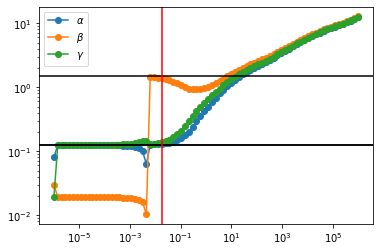

In [15]:
idx = 28
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

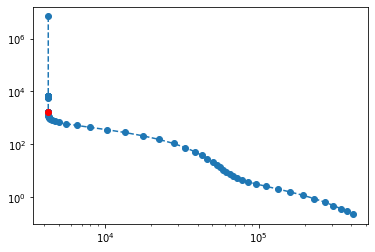

In [16]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

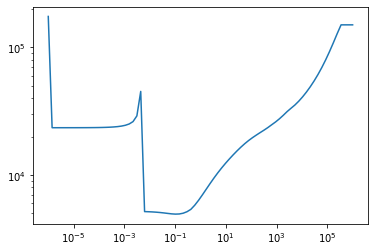

In [17]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

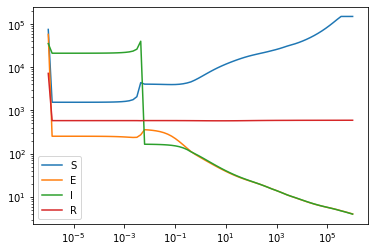

In [18]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIR")

In [19]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

(0, 20000)

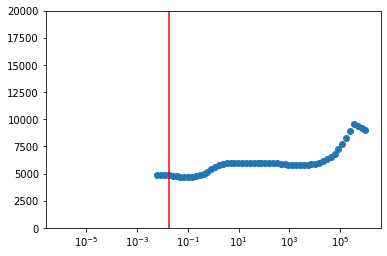

In [20]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [21]:
rinf(sols[idx])

4837.367067459117

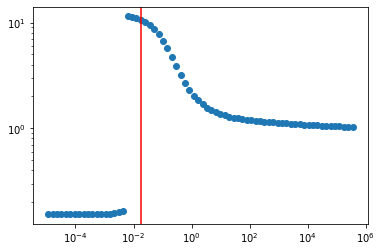

In [22]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [23]:
[getx(sols[idx]['x'])[i][50] for i in range(4)]

[DM(4498.32), DM(107.095), DM(11.3903), DM(388.479)]

In [24]:
getx(sols[idx]['x'])[0][0]

DM(4791.58)

In [25]:
getp(sols[idx]['x'])

(DM(0.13042), DM(1.3841), DM(0.137719))

In [26]:
r0(sols[idx])

10.612653871943964

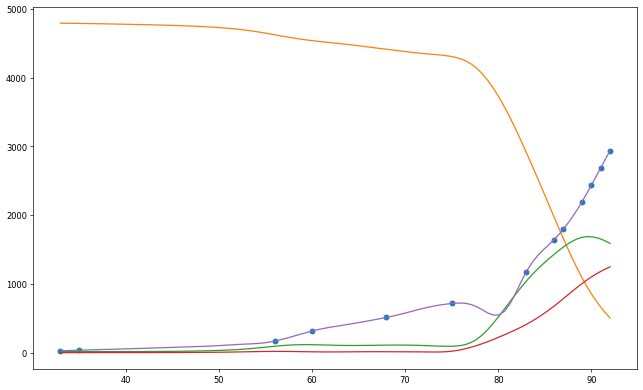

In [27]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')


In [28]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'max_iter': 300}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [29]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-2, 1, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4851

Total number of variables............................:       98
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   4  4.2868475e+03 0.00e+00 7.96e-01  -2.5 1.86e+02  -5.4 1.00e+00 1.00e+00f  1
   5  4.2843472e+03 0.00e+00 1.11e+01  -2.5 5.90e+02    -  1.00e+00 5.00e-01f  2
   6  4.2830200e+03 0.00e+00 1.60e-01  -2.5 1.07e+02  -5.9 1.00e+00 1.00e+00f  1
   7  4.2827938e+03 0.00e+00 2.28e+00  -2.5 3.61e+02    -  1.00e+00 2.50e-01f  3
   8  4.2825477e+03 0.00e+00 1.11e+00  -2.5 1.06e+02    -  1.00e+00 1.00e+00f  1
   9  4.2825148e+03 0.00e+00 2.48e-01  -2.5 3.72e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2825084e+03 0.00e+00 2.39e-01  -2.5 4.25e+01    -  1.00e+00 1.00e+00f  1
  11  4.2825072e+03 0.00e+00 3.81e-02  -2.5 1.96e+01    -  1.00e+00 1.00e+00f  1
  12  4.2825071e+03 0.00e+00 4.55e-03  -2.5 7.14e+00    -  1.00e+00 1.00e+00f  1
  13  4.2825071e+03 0.00e+00 4.27e-03  -3.8 6.66e+00    -  1.00e+00 1.00e+00f  1
  14  4.2825071e+03 0.00e+00 3.96e-07  -3.8 7.33e-02    -  1.00e+00 1.00e+00f  1
  15  4.2825071e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3117484e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.2970307e+03 0.00e+00 3.18e-01  -1.0 5.24e+01  -4.0 1.00e+00 1.00e+00f  1
   2  4.2935227e+03 0.00e+00 2.68e-02  -1.7 7.61e+01  -4.5 1.00e+00 1.00e+00f  1
   3  4.2896549e+03 0.00e+00 2.26e-02  -3.8 1.17e+02  -5.0 9.81e-01 1.00e+00f  1
   4  4.2858398e+03 0.00e+00 9.21e-01  -3.8 1.82e+02  -5.4 1.00e+00 1.00e+00f  1
   5  4.2834454e+03 0.00e+00 8.66e+00  -3.8 4.97e+02    -  1.00e+00 5.00e-01f  2
   6  4.2824465e+03 0.00e+00 1.10e-01  -3.8 1.04e+02  -5.9 1.00e+00 1.00e+00f  1
   7  4.2821895e+03 0.00e+00 3.20e+00  -3.8 1.81e+02    -  1.00e+00 5.00e-01f  2
   8  4.2820256e+03 0.00e+00 9.31e-02  -3.8 6.41e+01    -  1.00e+00 1.00e+00f  1
   9  4.2820107e+03 0.00e+00 2.65e-01  -3.8 5.23e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2820080e+03 0.00e+00

  13  4.2813752e+03 0.00e+00 1.42e-05  -5.7 6.41e-04    -  1.00e+00 2.50e-01f  3
  14  4.2813752e+03 0.00e+00 2.72e-05  -8.6 4.40e-03    -  1.00e+00 1.56e-02f  7
  15  4.2813752e+03 0.00e+00 2.04e-05  -8.6 4.33e-03    -  1.00e+00 2.50e-01f  3
  16  4.2813752e+03 0.00e+00 2.04e-05  -8.6 3.25e-03    -  1.00e+00 2.44e-04f 13
  17  4.2813752e+03 0.00e+00 2.04e-05  -8.6 3.25e-03    -  1.00e+00 2.44e-04f 13
  18  4.2813752e+03 0.00e+00 2.04e-05  -8.6 3.25e-03    -  1.00e+00 2.44e-04f 13
  19  4.2813752e+03 0.00e+00 2.04e-05  -8.6 3.25e-03    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2813752e+03 0.00e+00 2.04e-05  -8.6 3.25e-03    -  1.00e+00 7.63e-06f 18
  21  4.2813752e+03 0.00e+00 2.04e-05  -8.6 3.25e-03    -  1.00e+00 7.63e-06f 18
  22  4.2813752e+03 0.00e+00 2.04e-05  -8.6 3.25e-03    -  1.00e+00 7.63e-06f 18
  23  4.2813752e+03 0.00e+00 2.04e-05  -8.6 3.25e-03    -  1.00e+00 7.63e-06f 18
  24  4.2813752e+03 0.00e+00

  17  4.2805870e+03 0.00e+00 2.43e-05  -8.6 3.67e-03    -  1.00e+00 7.63e-06f 18
  18  4.2805870e+03 0.00e+00 2.43e-05  -8.6 3.67e-03    -  1.00e+00 7.63e-06f 18
  19  4.2805870e+03 0.00e+00 2.43e-05  -8.6 3.67e-03    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2805870e+03 0.00e+00 2.43e-05  -8.6 3.67e-03    -  1.00e+00 7.63e-06f 18
  21  4.2805870e+03 0.00e+00 2.43e-05  -8.6 3.67e-03    -  1.00e+00 7.63e-06f 18
  22  4.2805870e+03 0.00e+00 1.45e-09  -8.6 3.67e-03    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   5.4087973115331511e+02    4.2805870069623334e+03
Dual infeasibility......:   1.4451954360456228e-09    1.1437449861297580e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.9832021058349815e-08
Overall NLP error......

   0  4.2952890e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.2869292e+03 0.00e+00 1.88e-01  -1.0 4.82e+01  -4.0 1.00e+00 1.00e+00f  1
   2  4.2848075e+03 0.00e+00 4.40e-02  -2.5 6.73e+01  -4.5 1.00e+00 1.00e+00f  1
   3  4.2824377e+03 0.00e+00 1.36e-01  -2.5 1.04e+02  -5.0 1.00e+00 1.00e+00f  1
   4  4.2803763e+03 0.00e+00 1.76e+00  -2.5 1.46e+02  -5.4 1.00e+00 1.00e+00f  1
   5  4.2793799e+03 0.00e+00 9.43e+00  -2.5 2.31e+02    -  1.00e+00 1.00e+00f  1
   6  4.2791066e+03 0.00e+00 4.77e-02  -2.5 1.23e+01  -5.9 1.00e+00 1.00e+00f  1
   7  4.2790961e+03 0.00e+00 7.15e-01  -2.5 5.23e+01    -  1.00e+00 1.00e+00f  1
   8  4.2790927e+03 0.00e+00 2.24e-03  -2.5 3.24e+00    -  1.00e+00 1.00e+00f  1
   9  4.2790927e+03 0.00e+00 1.33e-04  -3.8 1.64e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2790927e+03 0.00e+00 7.12e-06  -5.7 2.39e-01    -  1.00e+00 1.00e+00f  1
  11  4.2790927e+03 0.00e+00

   7  4.2779259e+03 0.00e+00 1.36e-01  -2.5 3.82e+01    -  1.00e+00 1.00e+00f  1
   8  4.2779252e+03 0.00e+00 7.22e-02  -2.5 2.47e+01    -  1.00e+00 1.00e+00f  1
   9  4.2779252e+03 0.00e+00 1.20e-04  -2.5 8.82e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2779252e+03 0.00e+00 1.70e-03  -3.8 3.38e+00    -  1.00e+00 1.00e+00f  1
  11  4.2779252e+03 0.00e+00 7.23e-10  -3.8 7.01e-03    -  1.00e+00 1.00e+00f  1
  12  4.2779252e+03 0.00e+00 5.51e-06  -5.7 1.93e-01    -  1.00e+00 1.00e+00f  1
  13  4.2779252e+03 0.00e+00 9.49e-06  -8.6 2.41e-03    -  1.00e+00 5.00e-01f  2
  14  4.2779252e+03 0.00e+00 9.48e-06  -8.6 1.21e-03    -  1.00e+00 4.88e-04f 12
  15  4.2779252e+03 0.00e+00 9.47e-06  -8.6 1.21e-03    -  1.00e+00 1.95e-03f 10
  16  4.2779252e+03 0.00e+00 8.28e-06  -8.6 1.20e-03    -  1.00e+00 1.25e-01f  4
  17  4.2779252e+03 0.00e+00 8.28e-06  -8.6 1.05e-03    -  1.00e+00 4.88e-04f 12
  18  4.2779252e+03 0.00e+00

   1  4.2790453e+03 0.00e+00 3.80e-02  -1.0 4.01e+01  -4.0 1.00e+00 1.00e+00f  1
   2  4.2781718e+03 0.00e+00 2.29e-02  -2.5 5.24e+01  -4.5 1.00e+00 1.00e+00f  1
   3  4.2773307e+03 0.00e+00 6.62e-01  -3.8 7.35e+01  -5.0 1.00e+00 1.00e+00f  1
   4  4.2767929e+03 0.00e+00 6.97e+00  -3.8 1.39e+02    -  1.00e+00 1.00e+00f  1
   5  4.2767436e+03 0.00e+00 1.92e-02  -3.8 1.52e+01    -  1.00e+00 1.00e+00f  1
   6  4.2767429e+03 0.00e+00 2.06e-01  -3.8 3.23e+01    -  1.00e+00 1.00e+00f  1
   7  4.2767428e+03 0.00e+00 4.23e-05  -3.8 3.70e-01    -  1.00e+00 1.00e+00f  1
   8  4.2767428e+03 0.00e+00 3.48e-06  -5.7 1.30e-01    -  1.00e+00 1.00e+00f  1
   9  4.2767428e+03 0.00e+00 5.54e-10  -8.6 1.66e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.1310211034964848e+03    4.2767428394945819e+03
Dual infeasibility......:   5.5367057527194885e-10    2.0936007833212923e-09
Constraint viola

   1  4.2756137e+03 0.00e+00 5.97e-01  -1.0 5.55e+01    -  1.00e+00 1.00e+00f  1
   2  4.2756131e+03 0.00e+00 1.97e-01  -1.7 1.86e+01    -  1.00e+00 1.00e+00f  1
   3  4.2756131e+03 0.00e+00 2.00e-02  -2.5 5.36e+00    -  1.00e+00 1.00e+00f  1
   4  4.2756131e+03 0.00e+00 4.46e-04  -3.8 7.97e-01    -  1.00e+00 1.00e+00f  1
   5  4.2756131e+03 0.00e+00 9.63e-07  -5.7 3.70e-02    -  1.00e+00 1.00e+00f  1
   6  4.2756131e+03 0.00e+00 1.43e-05  -8.6 4.29e-04    -  1.00e+00 9.77e-04f 11
   7  4.2756131e+03 0.00e+00 1.43e-05  -8.6 4.28e-04    -  1.00e+00 9.77e-04f 11
   8  4.2756131e+03 0.00e+00 1.43e-05  -8.6 4.28e-04    -  1.00e+00 9.77e-04f 11
   9  4.2756131e+03 0.00e+00 1.43e-05  -8.6 4.28e-04    -  1.00e+00 9.77e-04f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2756131e+03 0.00e+00 1.43e-05  -8.6 4.27e-04    -  1.00e+00 9.77e-04f 11
  11  4.2756131e+03 0.00e+00 1.43e-05  -8.6 4.27e-04    -  1.00e+00 9.77e-04f 11
  12  4.2756131e+03 0.00e+00

  15  4.2763046e+03 0.00e+00 1.46e-05  -8.6 1.20e-03    -  1.00e+00 3.05e-05f 16
  16  4.2763046e+03 0.00e+00 1.46e-05  -8.6 1.20e-03    -  1.00e+00 3.05e-05f 16
  17  4.2763046e+03 0.00e+00 3.15e-10  -8.6 1.20e-03    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.4432394006348707e+03    4.2763046124195616e+03
Dual infeasibility......:   3.1526809473356697e-10    9.3413636508594767e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    7.4249684049815672e-09
Overall NLP error.......:   2.5059035596800622e-09    7.4249684049815672e-09


Number of objective function evaluations             = 183
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

   5  4.2835401e+03 0.00e+00 6.74e-04  -2.5 4.65e+00    -  1.00e+00 1.00e+00f  1
   6  4.2835401e+03 0.00e+00 8.56e-05  -3.8 2.81e+00    -  1.00e+00 1.00e+00f  1
   7  4.2835401e+03 0.00e+00 6.36e-06  -5.7 3.38e-01    -  1.00e+00 1.00e+00f  1
   8  4.2835401e+03 0.00e+00 1.47e-05  -8.6 4.27e-03    -  1.00e+00 2.50e-01f  3
   9  4.2835401e+03 0.00e+00 1.47e-05  -8.6 3.20e-03    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2835401e+03 0.00e+00 1.47e-05  -8.6 3.20e-03    -  1.00e+00 1.53e-05f 17
  11  4.2835401e+03 0.00e+00 1.47e-05  -8.6 3.20e-03    -  1.00e+00 1.53e-05f 17
  12  4.2835401e+03 0.00e+00 1.47e-05  -8.6 3.20e-03    -  1.00e+00 1.53e-05f 17
  13  4.2835401e+03 0.00e+00 1.47e-05  -8.6 3.20e-03    -  1.00e+00 1.53e-05f 17
  14  4.2835401e+03 0.00e+00 1.47e-05  -8.6 3.20e-03    -  1.00e+00 1.53e-05f 17
  15  4.2835401e+03 0.00e+00 1.47e-05  -8.6 3.20e-03    -  1.00e+00 1.53e-05f 17
  16  4.2835401e+03 0.00e+00

   5  4.3098939e+03 0.00e+00 2.95e-01  -2.5 1.09e+03    -  1.00e+00 2.50e-01f  3
   6  4.3097182e+03 0.00e+00 6.50e-01  -2.5 1.49e+02    -  1.00e+00 1.00e+00f  1
   7  4.3097092e+03 0.00e+00 7.79e-02  -2.5 7.77e+01    -  1.00e+00 1.00e+00f  1
   8  4.3097090e+03 0.00e+00 2.41e-03  -2.5 1.29e+01    -  1.00e+00 1.00e+00f  1
   9  4.3097089e+03 0.00e+00 1.78e-03  -3.8 9.78e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3097089e+03 0.00e+00 4.47e-07  -3.8 1.51e-01    -  1.00e+00 1.00e+00f  1
  11  4.3097089e+03 0.00e+00 1.04e-05  -5.7 6.86e-01    -  1.00e+00 1.00e+00f  1
  12  4.3097089e+03 0.00e+00 2.34e-05  -8.6 8.74e-03    -  1.00e+00 3.91e-03f  9
  13  4.3097089e+03 0.00e+00 2.30e-05  -8.6 8.71e-03    -  1.00e+00 1.56e-02f  7
  14  4.3097089e+03 0.00e+00 2.30e-05  -8.6 8.57e-03    -  1.00e+00 2.44e-04f 13
  15  4.3097089e+03 0.00e+00 2.30e-05  -8.6 8.57e-03    -  1.00e+00 6.10e-05f 15
  16  4.3097089e+03 0.00e+00

  12  4.3511911e+03 0.00e+00 2.12e-05  -5.7 1.26e+00    -  1.00e+00 1.00e+00f  1
  13  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.59e-03    -  1.00e+00 2.44e-04f 13
  14  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.59e-03    -  1.00e+00 4.88e-04f 12
  15  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.58e-03    -  1.00e+00 6.10e-05f 15
  16  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.58e-03    -  1.00e+00 7.63e-06f 18
  17  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.58e-03    -  1.00e+00 7.63e-06f 18
  18  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.58e-03    -  1.00e+00 7.63e-06f 18
  19  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.58e-03    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.58e-03    -  1.00e+00 7.63e-06f 18
  21  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.58e-03    -  1.00e+00 7.63e-06f 18
  22  4.3511911e+03 0.00e+00 2.12e-05  -5.7 7.58e-03    -  1.00e+00 7.63e-06f 18
  23  4.3511911e+03 0.00e+00

   2  4.4647422e+03 0.00e+00 1.74e+01  -1.0 8.43e+02    -  1.00e+00 1.00e+00f  1
   3  4.4357508e+03 0.00e+00 6.81e-02  -1.0 1.83e+01  -4.5 1.00e+00 1.00e+00f  1
   4  4.4336312e+03 0.00e+00 1.51e+00  -2.5 8.17e+03    -  2.73e-01 5.39e-02f  4
   5  4.4314070e+03 0.00e+00 2.74e-01  -2.5 2.63e+02    -  9.66e-01 1.00e+00f  1
   6  4.4313106e+03 0.00e+00 3.98e-01  -2.5 2.31e+02    -  1.00e+00 1.00e+00f  1
   7  4.4312761e+03 0.00e+00 2.45e-02  -2.5 6.61e+01    -  1.00e+00 1.00e+00f  1
   8  4.4312679e+03 0.00e+00 1.30e-01  -3.8 1.22e+02    -  1.00e+00 1.00e+00f  1
   9  4.4312646e+03 0.00e+00 1.85e-03  -3.8 1.69e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4312646e+03 0.00e+00 1.07e-03  -3.8 1.18e+01    -  1.00e+00 1.00e+00f  1
  11  4.4312645e+03 0.00e+00 2.12e-05  -5.7 1.64e+00    -  1.00e+00 1.00e+00f  1
  12  4.4312645e+03 0.00e+00 1.07e-09  -5.7 1.20e-02    -  1.00e+00 1.00e+00f  1
  13  4.4312645e+03 0.00e+00

   5  4.7200368e+03 0.00e+00 3.79e+00  -1.0 2.34e+02  -5.4 1.00e+00 1.00e+00f  1
   6  4.7048202e+03 0.00e+00 1.53e+00  -1.0 9.09e+01  -5.9 1.00e+00 1.00e+00f  1
   7  4.7016543e+03 0.00e+00 8.20e-01  -1.0 6.72e+01  -6.4 1.00e+00 1.00e+00f  1
   8  4.7008171e+03 0.00e+00 1.77e-01  -1.7 7.22e+01  -6.9 1.00e+00 1.00e+00f  1
   9  4.7003328e+03 0.00e+00 9.75e-02  -2.5 1.36e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6998135e+03 0.00e+00 2.76e-01  -2.5 2.33e+02  -7.8 1.00e+00 1.00e+00f  1
  11  4.6994055e+03 0.00e+00 1.27e+00  -2.5 1.28e+03    -  1.00e+00 2.50e-01f  3
  12  4.6990611e+03 0.00e+00 7.49e-01  -2.5 3.33e+02    -  1.00e+00 1.00e+00f  1
  13  4.6990179e+03 0.00e+00 4.36e-01  -2.5 7.02e+02    -  1.00e+00 2.50e-01f  3
  14  4.6989587e+03 0.00e+00 2.48e-01  -2.5 1.36e+02    -  1.00e+00 1.00e+00f  1
  15  4.6989534e+03 0.00e+00 9.73e-03  -2.5 2.52e+01    -  1.00e+00 1.00e+00f  1
  16  4.6989526e+03 0.00e+00

   3  5.2882188e+03 0.00e+00 3.61e+00  -1.0 3.52e+02  -5.0 1.00e+00 1.00e+00f  1
   4  5.1073968e+03 0.00e+00 2.41e+00  -1.0 2.84e+02  -5.4 1.00e+00 1.00e+00f  1
   5  5.0794230e+03 0.00e+00 1.16e+00  -1.0 9.68e+01  -5.9 1.00e+00 1.00e+00f  1
   6  5.0733305e+03 0.00e+00 5.41e-01  -1.0 6.57e+01  -6.4 1.00e+00 1.00e+00f  1
   7  5.0722399e+03 0.00e+00 1.25e-01  -1.7 6.17e+01  -6.9 1.00e+00 1.00e+00f  1
   8  5.0720435e+03 0.00e+00 9.92e-02  -2.5 2.10e+02    -  1.00e+00 1.00e+00f  1
   9  5.0719926e+03 0.00e+00 2.32e-02  -2.5 1.17e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0719749e+03 0.00e+00 8.45e-02  -3.8 1.61e+02    -  1.00e+00 1.00e+00f  1
  11  5.0719668e+03 0.00e+00 3.41e-03  -3.8 3.74e+01    -  1.00e+00 1.00e+00f  1
  12  5.0719661e+03 0.00e+00 3.37e-03  -3.8 3.56e+01    -  1.00e+00 1.00e+00f  1
  13  5.0719661e+03 0.00e+00 1.19e-05  -3.8 2.20e+00    -  1.00e+00 1.00e+00f  1
  14  5.0719661e+03 0.00e+00

  10  5.7463273e+03 0.00e+00 4.77e-02  -3.8 1.48e+02    -  1.00e+00 1.00e+00f  1
  11  5.7463199e+03 0.00e+00 6.77e-03  -3.8 6.12e+01    -  1.00e+00 1.00e+00f  1
  12  5.7463188e+03 0.00e+00 3.32e-03  -3.8 4.28e+01    -  1.00e+00 1.00e+00f  1
  13  5.7463188e+03 0.00e+00 5.93e-05  -3.8 5.84e+00    -  1.00e+00 1.00e+00f  1
  14  5.7463188e+03 0.00e+00 3.92e-05  -5.7 4.62e+00    -  1.00e+00 1.00e+00f  1
  15  5.7463188e+03 0.00e+00 2.74e-10  -5.7 1.44e-02    -  1.00e+00 1.00e+00f  1
  16  5.7463188e+03 0.00e+00 5.11e-09  -8.6 5.38e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   4.2221230069310799e+01    5.7463187680042838e+03
Dual infeasibility......:   5.1141418257989171e-09    6.9603583570590462e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5272792718761236e-09    3.4396326890830992e-07
Overall NLP error......

   1  1.4754400e+04 0.00e+00 7.18e+00  -1.0 2.32e+02  -4.0 2.89e-01 1.00e+00f  1
   2  1.0220906e+04 0.00e+00 2.01e+00  -1.0 4.00e+02  -4.5 8.58e-01 1.00e+00f  1
   3  8.2411465e+03 0.00e+00 2.63e+00  -1.0 3.67e+02  -5.0 1.00e+00 1.00e+00f  1
   4  7.9509930e+03 0.00e+00 1.45e+00  -1.0 1.93e+02  -5.4 1.00e+00 1.00e+00f  1
   5  7.8997200e+03 0.00e+00 8.29e-01  -1.0 6.42e+01  -5.9 1.00e+00 1.00e+00f  1
   6  7.8855789e+03 0.00e+00 3.45e-01  -1.7 5.19e+01  -6.4 1.00e+00 1.00e+00f  1
   7  7.8821193e+03 0.00e+00 1.81e-01  -1.7 8.14e+01  -6.9 1.00e+00 1.00e+00f  1
   8  7.8817407e+03 0.00e+00 1.27e-01  -2.5 8.56e+02    -  7.48e-01 2.50e-01f  3
   9  7.8812146e+03 0.00e+00 4.18e-02  -2.5 3.49e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.8811540e+03 0.00e+00 6.08e-03  -2.5 1.37e+02    -  1.00e+00 1.00e+00f  1
  11  7.8811313e+03 0.00e+00 4.70e-02  -3.8 1.88e+02    -  1.00e+00 1.00e+00f  1
  12  7.8811208e+03 0.00e+00

   4  1.0850269e+04 0.00e+00 1.10e+00  -1.0 1.47e+02  -5.4 1.00e+00 1.00e+00f  1
   5  1.0786449e+04 0.00e+00 8.03e-01  -1.0 6.06e+01  -5.9 1.00e+00 1.00e+00f  1
   6  1.0767332e+04 0.00e+00 2.54e-01  -1.7 5.24e+01  -6.4 9.77e-01 1.00e+00f  1
   7  1.0762505e+04 0.00e+00 2.09e-01  -1.7 7.80e+01  -6.9 1.00e+00 1.00e+00f  1
   8  1.0761329e+04 0.00e+00 2.05e-02  -1.7 1.03e+02  -7.3 1.00e+00 1.00e+00f  1
   9  1.0761062e+04 0.00e+00 1.09e-01  -3.8 4.18e+02    -  9.32e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0760951e+04 0.00e+00 2.09e-02  -3.8 1.60e+02    -  1.00e+00 1.00e+00f  1
  11  1.0760916e+04 0.00e+00 2.62e-02  -3.8 1.78e+02    -  1.00e+00 1.00e+00f  1
  12  1.0760902e+04 0.00e+00 4.49e-03  -3.8 7.59e+01    -  1.00e+00 1.00e+00f  1
  13  1.0760899e+04 0.00e+00 3.47e-03  -3.8 6.75e+01    -  1.00e+00 1.00e+00f  1
  14  1.0760899e+04 0.00e+00 1.01e-04  -3.8 1.18e+01    -  1.00e+00 1.00e+00f  1
  15  1.0760899e+04 0.00e+00

   9  1.5872056e+04 0.00e+00 2.11e-02  -3.8 7.98e+02    -  8.27e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5871828e+04 0.00e+00 2.42e-03  -3.8 1.66e+02    -  1.00e+00 1.00e+00f  1
  11  1.5871787e+04 0.00e+00 2.28e-02  -3.8 1.91e+02    -  1.00e+00 1.00e+00f  1
  12  1.5871771e+04 0.00e+00 3.88e-03  -3.8 8.24e+01    -  1.00e+00 1.00e+00f  1
  13  1.5871768e+04 0.00e+00 2.85e-03  -3.8 7.16e+01    -  1.00e+00 1.00e+00f  1
  14  1.5871768e+04 0.00e+00 1.10e-04  -3.8 1.45e+01    -  1.00e+00 1.00e+00f  1
  15  1.5871767e+04 0.00e+00 1.02e-04  -5.7 1.34e+01    -  1.00e+00 1.00e+00f  1
  16  1.5871767e+04 0.00e+00 1.06e-08  -5.7 1.51e-01    -  1.00e+00 1.00e+00f  1
  17  1.5871767e+04 0.00e+00 1.14e-08  -8.6 1.47e-01    -  1.00e+00 1.00e+00f  1
  18  1.5871767e+04 0.00e+00 7.78e-13  -9.0 1.36e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objecti

   3  2.5386490e+04 0.00e+00 9.94e-01  -1.7 2.71e+02  -5.0 1.00e+00 1.00e+00f  1
   4  2.5153396e+04 0.00e+00 4.63e-01  -1.7 5.85e+01  -5.4 7.11e-01 1.00e+00f  1
   5  2.4977974e+04 0.00e+00 4.70e-01  -1.7 4.17e+03  -5.9 1.00e+00 2.26e-02f  4
   6  2.4934489e+04 0.00e+00 5.44e-01  -1.7 5.37e+01  -6.4 1.00e+00 1.00e+00f  1
   7  2.4933022e+04 0.00e+00 1.98e-01  -1.7 1.15e+02  -6.9 1.00e+00 1.00e+00f  1
   8  2.4925030e+04 0.00e+00 7.10e-02  -2.5 1.76e+02  -7.3 1.00e+00 1.00e+00f  1
   9  2.4922871e+04 0.00e+00 2.29e-01  -2.5 1.87e+02  -6.9 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4920989e+04 0.00e+00 6.02e-03  -2.5 5.19e+01  -7.4 1.00e+00 1.00e+00f  1
  11  2.4920750e+04 0.00e+00 1.30e-01  -3.8 7.14e+02    -  7.76e-01 5.00e-01f  2
  12  2.4920017e+04 0.00e+00 6.80e-03  -3.8 2.02e+02    -  1.00e+00 1.00e+00f  1
  13  2.4919935e+04 0.00e+00 2.74e-02  -3.8 4.20e+02    -  1.00e+00 5.00e-01f  2
  14  2.4919882e+04 0.00e+00

   6  4.0948982e+04 0.00e+00 1.41e+00  -1.7 9.17e+01  -3.7 2.00e-01 1.25e-01f  4
   7  4.0916448e+04 0.00e+00 6.44e-02  -1.7 8.92e+00  -4.2 1.00e+00 1.00e+00f  1
   8  4.0914122e+04 0.00e+00 3.13e-02  -2.5 4.66e+00  -4.6 1.00e+00 1.00e+00f  1
   9  4.0912804e+04 0.00e+00 1.92e-01  -2.5 2.75e+03    -  6.01e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.0909243e+04 0.00e+00 5.19e-02  -2.5 5.60e+02    -  1.00e+00 1.00e+00f  1
  11  4.0909092e+04 0.00e+00 1.48e-03  -2.5 5.19e+01    -  1.00e+00 1.00e+00f  1
  12  4.0909055e+04 0.00e+00 4.38e-02  -3.8 3.41e+02    -  1.00e+00 1.00e+00f  1
  13  4.0908969e+04 0.00e+00 6.52e-04  -3.8 4.01e+01    -  1.00e+00 1.00e+00f  1
  14  4.0908967e+04 0.00e+00 1.36e-03  -5.7 6.62e+01    -  1.00e+00 1.00e+00f  1
  15  4.0908967e+04 0.00e+00 1.29e-07  -5.7 1.42e+00    -  1.00e+00 1.00e+00f  1
  16  4.0908967e+04 0.00e+00 3.75e-08  -8.6 3.41e-01    -  1.00e+00 1.00e+00f  1
  17  4.0908967e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3603770e+03 0.00e+00 3.03e+00  -2.5 5.19e+03    -  1.00e+00 2.50e-01f  3
  11  4.3590312e+03 0.00e+00 1.08e+00  -2.5 2.81e+02  -7.4 1.00e+00 1.00e+00f  1
  12  4.3589147e+03 0.00e+00 1.04e+00  -2.5 2.39e+02  -7.9 1.00e+00 1.00e+00f  1
  13  4.3588689e+03 0.00e+00 1.29e+00  -2.5 5.23e+02  -8.3 1.00e+00 1.00e+00f  1
  14  4.3588138e+03 0.00e+00 1.01e+00  -2.5 1.84e+02  -7.9 1.00e+00 1.00e+00f  1
  15  4.3587664e+03 0.00e+00 7.30e-01  -2.5 4.07e+02  -8.4 1.00e+00 1.00e+00f  1
  16  4.3587141e+03 0.00e+00 4.50e-01  -2.5 5.69e+03  -8.9 1.00e+00 6.25e-02f  5
  17  4.3584786e+03 0.00e+00 4.35e+00  -2.5 3.87e+03    -  1.00e+00 5.00e-01f  2
  18  4.3583812e+03 0.00e+00 5.20e-03  -2.5 4.37e+01  -7.5 1.00e+00 1.00e+00f  1
  19  4.3583286e+03 0.00e+00 1.21e+00  -3.8 1.57e+02  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.3582307e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.3572334e+03 0.00e+00 3.19e+00  -2.5 6.64e+02  -8.5 1.00e+00 1.00e+00f  1
  21  4.3556063e+03 0.00e+00 5.03e+01  -2.5 1.19e+04    -  1.00e+00 5.00e-01f  2
  22  4.3524900e+03 0.00e+00 1.83e+00  -2.5 1.35e+02  -7.2 1.00e+00 1.00e+00f  1
  23  4.3509375e+03 0.00e+00 6.52e+00  -2.5 4.23e+02  -7.6 1.00e+00 1.00e+00f  1
  24  4.3485613e+03 0.00e+00 1.41e+01  -2.5 8.32e+02  -8.1 1.00e+00 1.00e+00f  1
  25  4.3472946e+03 0.00e+00 4.16e+01  -2.5 1.62e+04    -  1.00e+00 8.89e-01f  1
  26  4.3424590e+03 0.00e+00 9.93e-01  -2.5 1.31e+02  -5.9 1.00e+00 1.00e+00f  1
  27  4.3332839e+03 0.00e+00 9.57e+01  -2.5 2.63e+04    -  1.00e+00 7.04e-01f  1
  28  4.3308144e+03 0.00e+00 1.83e+01  -2.5 2.89e+04    -  1.00e+00 1.00e+00f  1
  29  4.3298007e+03 0.00e+00 1.83e+00  -2.5 3.22e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.3292777e+03 0.00e+00

  27  4.3307191e+03 0.00e+00 3.87e+00  -2.5 3.40e+04    -  1.00e+00 1.00e+00f  1
  28  4.3298611e+03 0.00e+00 3.19e+00  -2.5 4.17e+02  -7.2 1.00e+00 2.50e-01f  3
  29  4.3286349e+03 0.00e+00 2.52e+00  -2.5 2.30e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.3280258e+03 0.00e+00 4.58e-01  -2.5 4.76e+04    -  1.00e+00 1.00e+00f  1
  31  4.3276196e+03 0.00e+00 2.17e-01  -2.5 6.14e+04    -  1.00e+00 1.00e+00f  1
  32  4.3273340e+03 0.00e+00 1.86e-01  -2.5 9.52e+04    -  1.00e+00 1.00e+00f  1
  33  4.3271361e+03 0.00e+00 1.29e-01  -2.5 1.41e+05    -  1.00e+00 1.00e+00f  1
  34  4.3269999e+03 0.00e+00 9.14e-02  -2.5 2.11e+05    -  1.00e+00 1.00e+00f  1
  35  4.3269070e+03 0.00e+00 6.34e-02  -2.5 3.15e+05    -  1.00e+00 1.00e+00f  1
  36  4.3268441e+03 0.00e+00 4.36e-02  -2.5 4.73e+05    -  1.00e+00 1.00e+00f  1
  37  4.3268017e+03 0.00e+00 2.97e-02  -2.5 7.09e+05    -  1.00e+00 1.00e+00f  1
  38  4.3267731e+03 0.00e+00

  31  4.3257623e+03 0.00e+00 1.73e-01  -2.5 9.62e+04    -  1.00e+00 1.00e+00f  1
  32  4.3255631e+03 0.00e+00 1.24e-01  -2.5 1.44e+05    -  1.00e+00 1.00e+00f  1
  33  4.3254266e+03 0.00e+00 8.68e-02  -2.5 2.15e+05    -  1.00e+00 1.00e+00f  1
  34  4.3253338e+03 0.00e+00 6.01e-02  -2.5 3.22e+05    -  1.00e+00 1.00e+00f  1
  35  4.3252710e+03 0.00e+00 4.12e-02  -2.5 4.83e+05    -  1.00e+00 1.00e+00f  1
  36  4.3252288e+03 0.00e+00 2.80e-02  -2.5 7.24e+05    -  1.00e+00 1.00e+00f  1
  37  4.3251290e+03 0.00e+00 1.86e-02  -3.8 1.09e+06    -  1.00e+00 1.00e+00f  1
  38  4.3251101e+03 0.00e+00 1.28e-02  -3.8 1.63e+06    -  1.00e+00 1.00e+00f  1
  39  4.3250974e+03 0.00e+00 8.59e-03  -3.8 2.45e+06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.3250889e+03 0.00e+00 5.75e-03  -3.8 3.67e+06    -  1.00e+00 1.00e+00f  1
  41  4.3250832e+03 0.00e+00 3.85e-03  -3.8 5.50e+06    -  1.00e+00 1.00e+00f  1
  42  4.3250794e+03 0.00e+00

  37  4.3234854e+03 0.00e+00 5.89e-02  -3.8 3.23e+05    -  1.00e+00 1.00e+00f  1
  38  4.3234218e+03 0.00e+00 4.03e-02  -3.8 4.84e+05    -  1.00e+00 1.00e+00f  1
  39  4.3233790e+03 0.00e+00 2.73e-02  -3.8 7.26e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.3233503e+03 0.00e+00 1.85e-02  -3.8 1.09e+06    -  1.00e+00 1.00e+00f  1
  41  4.3233311e+03 0.00e+00 1.24e-02  -3.8 1.63e+06    -  1.00e+00 1.00e+00f  1
  42  4.3233183e+03 0.00e+00 8.33e-03  -3.8 2.45e+06    -  1.00e+00 1.00e+00f  1
  43  4.3233097e+03 0.00e+00 5.57e-03  -3.8 3.67e+06    -  1.00e+00 1.00e+00f  1
  44  4.3233039e+03 0.00e+00 3.73e-03  -3.8 5.51e+06    -  1.00e+00 1.00e+00f  1
  45  4.3233001e+03 0.00e+00 2.49e-03  -3.8 8.26e+06    -  1.00e+00 1.00e+00f  1
  46  4.3232976e+03 0.00e+00 1.67e-03  -3.8 1.24e+07    -  1.00e+00 1.00e+00f  1
  47  4.3232958e+03 0.00e+00 1.17e-03  -3.8 1.93e+07    -  1.00e+00 1.00e+00f  1
  48  4.3232906e+03 0.00e+00

   5  4.4425883e+03 0.00e+00 3.89e+00  -2.5 6.57e+02  -5.9 1.00e+00 1.00e+00f  1
   6  4.3853266e+03 0.00e+00 1.08e+01  -2.5 7.46e+02  -6.4 1.00e+00 1.00e+00f  1
   7  4.3712399e+03 0.00e+00 9.10e-01  -2.5 1.91e+02  -6.0 1.00e+00 1.00e+00f  1
   8  4.3624964e+03 0.00e+00 4.38e-01  -2.5 2.94e+02  -6.4 1.00e+00 1.00e+00f  1
   9  4.3566802e+03 0.00e+00 1.43e+00  -2.5 3.00e+02  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3540520e+03 0.00e+00 2.18e+00  -2.5 2.95e+02  -7.4 1.00e+00 1.00e+00f  1
  11  4.3512100e+03 0.00e+00 1.18e+01  -2.5 6.92e+02  -7.9 1.00e+00 1.00e+00f  1
  12  4.3508547e+03 0.00e+00 3.25e+01  -2.5 2.32e+03  -8.3 2.13e-01 5.00e-01f  2
  13  4.3470793e+03 0.00e+00 5.35e+00  -2.5 3.05e+02  -7.0 1.00e+00 1.00e+00f  1
  14  4.3431652e+03 0.00e+00 9.13e+00  -2.5 1.58e+04    -  1.00e+00 1.04e-01f  1
  15  4.3332541e+03 0.00e+00 5.26e+01  -2.5 8.86e+03    -  1.00e+00 1.00e+00f  1
  16  4.3287358e+03 0.00e+00

  33  4.3166317e+03 0.00e+00 3.22e-03  -3.8 6.26e+06    -  1.00e+00 1.00e+00f  1
  34  4.3166283e+03 0.00e+00 2.17e-03  -3.8 9.43e+06    -  1.00e+00 1.00e+00f  1
  35  4.3166260e+03 0.00e+00 1.45e-03  -3.8 1.42e+07    -  1.00e+00 1.00e+00f  1
  36  4.3166206e+03 0.00e+00 9.12e-04  -5.7 2.07e+07    -  1.00e+00 1.00e+00f  1
  37  4.3166198e+03 0.00e+00 3.88e-04  -5.7 2.34e+07    -  1.00e+00 1.00e+00f  1
  38  4.3166192e+03 0.00e+00 2.34e-04  -5.7 2.88e+07    -  1.00e+00 1.00e+00f  1
  39  4.3166191e+03 0.00e+00 2.59e-05  -5.7 1.35e+07    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.3166189e+03 0.00e+00 2.24e-05  -5.7 1.48e+07    -  1.00e+00 1.00e+00f  1
  41  4.3166188e+03 0.00e+00 8.98e-06  -5.7 1.08e+07    -  1.00e+00 1.00e+00f  1
  42  4.3166185e+03 0.00e+00 6.42e-05  -8.6 3.45e+07    -  1.00e+00 1.00e+00f  1
  43  4.3166185e+03 0.00e+00 4.46e-11  -8.6 2.83e-03  -8.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 4

   3  4.6402872e+03 0.00e+00 8.93e-02  -2.5 1.98e+02  -5.0 1.00e+00 1.00e+00f  1
   4  4.5372893e+03 0.00e+00 4.87e-01  -2.5 4.07e+02  -5.4 1.00e+00 1.00e+00f  1
   5  4.4321792e+03 0.00e+00 4.30e+00  -2.5 6.47e+02  -5.9 1.00e+00 1.00e+00f  1
   6  4.3748768e+03 0.00e+00 9.99e+00  -2.5 7.12e+02  -6.4 1.00e+00 1.00e+00f  1
   7  4.3626949e+03 0.00e+00 5.01e-01  -2.5 1.78e+02  -6.0 1.00e+00 1.00e+00f  1
   8  4.3544086e+03 0.00e+00 2.34e-01  -2.5 2.60e+02  -6.4 1.00e+00 1.00e+00f  1
   9  4.3488887e+03 0.00e+00 2.42e+00  -2.5 2.87e+02  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3428672e+03 0.00e+00 1.42e+01  -2.5 3.17e+04    -  1.00e+00 5.44e-02f  1
  11  4.3308823e+03 0.00e+00 7.53e+01  -2.5 1.08e+04    -  5.52e-01 1.00e+00f  1
  12  4.3292699e+03 0.00e+00 6.74e+01  -2.5 1.36e+03  -7.4 1.00e+00 7.08e-02f  1
  13  4.3235200e+03 0.00e+00 4.77e+01  -2.5 1.10e+05    -  2.23e-02 1.25e-01f  4
  14  4.3229069e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.3086616e+03 0.00e+00 1.25e-01  -2.5 1.48e+05    -  1.00e+00 1.00e+00f  1
  21  4.3085373e+03 0.00e+00 8.82e-02  -2.5 2.22e+05    -  1.00e+00 1.00e+00f  1
  22  4.3084529e+03 0.00e+00 6.12e-02  -2.5 3.32e+05    -  1.00e+00 1.00e+00f  1
  23  4.3083959e+03 0.00e+00 4.20e-02  -2.5 4.97e+05    -  1.00e+00 1.00e+00f  1
  24  4.3083575e+03 0.00e+00 2.86e-02  -2.5 7.46e+05    -  1.00e+00 1.00e+00f  1
  25  4.3083318e+03 0.00e+00 1.93e-02  -2.5 1.12e+06    -  1.00e+00 1.00e+00f  1
  26  4.3082448e+03 0.00e+00 1.26e-02  -3.8 1.68e+06    -  1.00e+00 1.00e+00f  1
  27  4.3082331e+03 0.00e+00 8.79e-03  -3.8 2.52e+06    -  1.00e+00 1.00e+00f  1
  28  4.3082254e+03 0.00e+00 5.90e-03  -3.8 3.78e+06    -  1.00e+00 1.00e+00f  1
  29  4.3082202e+03 0.00e+00 3.94e-03  -3.8 5.66e+06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.3082168e+03 0.00e+00

  34  4.3052190e+03 0.00e+00 7.73e-05  -5.7 2.41e+07    -  1.00e+00 1.00e+00f  1
  35  4.3052189e+03 0.00e+00 1.24e-05  -5.7 1.20e+07    -  1.00e+00 1.00e+00f  1
  36  4.3052188e+03 0.00e+00 8.20e-06  -8.6 1.10e+07    -  1.00e+00 1.00e+00f  1
  37  4.3052187e+03 0.00e+00 8.08e-06  -8.6 1.20e+07    -  1.00e+00 1.00e+00f  1
  38  4.3052186e+03 0.00e+00 1.79e-05  -8.6 2.03e+07    -  1.00e+00 1.00e+00f  1
  39  4.3052186e+03 0.00e+00 4.95e-06  -8.6 1.22e+07    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.3052185e+03 0.00e+00 2.55e-06  -8.6 9.49e+06    -  1.00e+00 1.00e+00f  1
  41  4.3052185e+03 0.00e+00 1.99e-11  -8.6 8.00e-05  -7.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   1.6561901246871528e+02    4.3052185430187219e+03
Dual infeasibility......:   1.9901699278528384e-11    5.1733894251837498e-10
Constraint viol

   1  4.7134078e+03 0.00e+00 2.49e-01  -1.0 4.03e+01  -4.0 1.00e+00 1.00e+00f  1
   2  4.6833613e+03 0.00e+00 5.15e-02  -1.7 9.14e+01  -4.5 1.00e+00 1.00e+00f  1
   3  4.6185079e+03 0.00e+00 6.91e-03  -2.5 1.98e+02  -5.0 1.00e+00 1.00e+00f  1
   4  4.5128389e+03 0.00e+00 9.54e-01  -3.8 4.04e+02  -5.4 7.37e-01 1.00e+00f  1
   5  4.4077171e+03 0.00e+00 4.80e+00  -3.8 6.22e+02  -5.9 9.58e-01 1.00e+00f  1
   6  4.3537635e+03 0.00e+00 8.38e+00  -3.8 6.28e+02  -6.4 1.00e+00 1.00e+00f  1
   7  4.3369236e+03 0.00e+00 8.44e+00  -3.8 5.91e+02  -6.9 1.00e+00 1.00e+00f  1
   8  4.3250357e+03 0.00e+00 6.31e+00  -3.8 7.16e+03    -  1.00e+00 3.38e-01f  1
   9  4.3142427e+03 0.00e+00 1.04e+01  -3.8 5.59e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3094344e+03 0.00e+00 2.80e+00  -3.8 5.21e+03    -  1.00e+00 8.27e-01f  1
  11  4.3065695e+03 0.00e+00 1.08e+00  -3.8 5.54e+03    -  1.00e+00 1.00e+00f  1
  12  4.3045383e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2968045e+03 0.00e+00 4.36e-03  -3.8 6.67e+06    -  1.00e+00 1.00e+00f  1
  31  4.2968026e+03 0.00e+00 2.95e-03  -3.8 1.01e+07    -  1.00e+00 1.00e+00f  1
  32  4.2968013e+03 0.00e+00 1.92e-03  -3.8 1.49e+07    -  1.00e+00 1.00e+00f  1
  33  4.2968004e+03 0.00e+00 1.34e-03  -3.8 2.28e+07    -  1.00e+00 1.00e+00f  1
  34  4.2967963e+03 0.00e+00 3.30e-04  -5.7 1.94e+07    -  1.00e+00 1.00e+00f  1
  35  4.2967956e+03 0.00e+00 1.97e-03  -5.7 8.54e+07    -  1.00e+00 1.00e+00f  1
  36  4.2967956e+03 0.00e+00 2.20e-08  -5.7 4.25e-02  -7.3 1.00e+00 1.00e+00f  1
  37  4.2967956e+03 0.00e+00 2.06e-09  -8.6 1.35e-02  -7.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.6842166456447595e+02    4.2967955658748742e+03
Dual infeasibility......:   2.0615145146507530e-09    5.2593628310489861e-08
Constraint viol

  11  4.2985702e+03 0.00e+00 8.53e-01  -2.5 3.80e+03    -  1.00e+00 1.00e+00f  1
  12  4.2968732e+03 0.00e+00 1.44e+00  -2.5 5.53e+03    -  1.00e+00 1.00e+00f  1
  13  4.2956711e+03 0.00e+00 7.98e-01  -2.5 6.54e+03    -  1.00e+00 1.00e+00f  1
  14  4.2948137e+03 0.00e+00 9.20e-01  -2.5 9.35e+03    -  1.00e+00 1.00e+00f  1
  15  4.2941907e+03 0.00e+00 6.48e-01  -2.5 1.19e+04    -  1.00e+00 1.00e+00f  1
  16  4.2937343e+03 0.00e+00 6.05e-01  -2.5 1.67e+04    -  1.00e+00 1.00e+00f  1
  17  4.2933979e+03 0.00e+00 4.74e-01  -2.5 2.26e+04    -  1.00e+00 1.00e+00f  1
  18  4.2931493e+03 0.00e+00 4.02e-01  -2.5 3.20e+04    -  1.00e+00 1.00e+00f  1
  19  4.2929661e+03 0.00e+00 3.21e-01  -2.5 4.50e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2928317e+03 0.00e+00 2.58e-01  -2.5 6.46e+04    -  1.00e+00 1.00e+00f  1
  21  4.2927338e+03 0.00e+00 2.02e-01  -2.5 9.35e+04    -  1.00e+00 1.00e+00f  1
  22  4.2926632e+03 0.00e+00

  34  4.2908104e+03 0.00e+00 3.77e-03  -3.8 1.04e+07    -  1.00e+00 1.00e+00f  1
  35  4.2908098e+03 0.00e+00 2.41e-03  -3.8 1.52e+07    -  1.00e+00 1.00e+00f  1
  36  4.2908097e+03 0.00e+00 3.26e-04  -3.8 9.14e+06    -  1.00e+00 1.00e+00f  1
  37  4.2908080e+03 0.00e+00 1.29e-03  -5.7 1.89e+07    -  1.00e+00 1.00e+00f  1
  38  4.2908076e+03 0.00e+00 1.75e-04  -5.7 4.10e+00  -7.3 1.00e+00 1.00e+00f  1
  39  4.2908075e+03 0.00e+00 1.14e-04  -5.7 3.84e+00  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.2908074e+03 0.00e+00 1.57e-04  -5.7 1.29e+07    -  1.00e+00 1.00e+00f  1
  41  4.2908073e+03 0.00e+00 6.34e-05  -5.7 1.00e+07    -  1.00e+00 1.00e+00f  1
  42  4.2908072e+03 0.00e+00 8.28e-05  -5.7 1.37e+07    -  1.00e+00 1.00e+00f  1
  43  4.2908072e+03 0.00e+00 3.66e-05  -5.7 1.09e+07    -  1.00e+00 1.00e+00f  1
  44  4.2908072e+03 0.00e+00 4.56e-06  -5.7 4.28e+06    -  1.00e+00 1.00e+00f  1
  45  4.2908071e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7587111e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.6563630e+03 0.00e+00 2.23e-01  -1.0 4.06e+01  -4.0 1.00e+00 1.00e+00f  1
   2  4.6204794e+03 0.00e+00 3.05e-02  -1.7 9.13e+01  -4.5 1.00e+00 1.00e+00f  1
   3  4.5463877e+03 0.00e+00 4.30e-01  -2.5 1.97e+02  -5.0 1.00e+00 1.00e+00f  1
   4  4.4367693e+03 0.00e+00 2.25e+00  -2.5 3.84e+02  -5.4 1.00e+00 1.00e+00f  1
   5  4.3473923e+03 0.00e+00 4.87e+00  -2.5 5.28e+02  -5.9 1.00e+00 1.00e+00f  1
   6  4.3186592e+03 0.00e+00 6.74e+00  -2.5 3.92e+02  -6.4 1.00e+00 1.00e+00f  1
   7  4.3087953e+03 0.00e+00 1.14e+01  -2.5 5.96e+03    -  1.00e+00 2.12e-01f  1
   8  4.2986839e+03 0.00e+00 3.03e+00  -2.5 2.88e+03    -  1.00e+00 1.00e+00f  1
   9  4.2949559e+03 0.00e+00 1.79e+00  -2.5 2.23e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2929221e+03 0.00e+00

   7  4.3085264e+03 0.00e+00 1.55e+01  -3.8 4.04e+02  -6.4 7.21e-03 1.00e+00f  1
   8  4.3024659e+03 0.00e+00 6.46e+00  -3.8 3.59e+02  -6.9 1.00e+00 5.20e-01f  1
   9  4.2966402e+03 0.00e+00 7.39e+00  -3.8 2.91e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2950794e+03 0.00e+00 1.63e+00  -3.8 4.64e+02  -7.3 1.00e+00 2.92e-01f  2
  11  4.2921917e+03 0.00e+00 8.83e-01  -3.8 1.81e+03    -  1.00e+00 1.00e+00f  1
  12  4.2908413e+03 0.00e+00 2.28e+00  -3.8 2.65e+03    -  7.13e-01 1.00e+00f  1
  13  4.2898198e+03 0.00e+00 1.60e+00  -3.8 2.08e+03    -  1.00e+00 1.00e+00f  1
  14  4.2890099e+03 0.00e+00 9.43e-01  -3.8 3.41e+03    -  9.31e-01 1.00e+00f  1
  15  4.2884141e+03 0.00e+00 1.25e+00  -3.8 3.93e+03    -  1.00e+00 1.00e+00f  1
  16  4.2879335e+03 0.00e+00 8.16e-01  -3.8 4.82e+03    -  1.00e+00 1.00e+00f  1
  17  4.2875577e+03 0.00e+00 9.39e-01  -3.8 6.67e+03    -  1.00e+00 1.00e+00f  1
  18  4.2872539e+03 0.00e+00

  21  4.2852134e+03 0.00e+00 1.01e+00  -3.8 1.79e+04    -  1.00e+00 1.00e+00f  1
  22  4.2850608e+03 0.00e+00 2.11e-01  -3.8 1.37e+04    -  1.00e+00 1.00e+00f  1
  23  4.2849540e+03 0.00e+00 5.51e-01  -3.8 2.90e+04    -  1.00e+00 1.00e+00f  1
  24  4.2848695e+03 0.00e+00 2.19e-01  -3.8 2.92e+04    -  1.00e+00 1.00e+00f  1
  25  4.2848050e+03 0.00e+00 3.05e-01  -3.8 5.01e+04    -  1.00e+00 1.00e+00f  1
  26  4.2847560e+03 0.00e+00 1.87e-01  -3.8 6.23e+04    -  1.00e+00 1.00e+00f  1
  27  4.2847187e+03 0.00e+00 1.78e-01  -3.8 9.47e+04    -  1.00e+00 1.00e+00f  1
  28  4.2846909e+03 0.00e+00 1.31e-01  -3.8 1.32e+05    -  1.00e+00 1.00e+00f  1
  29  4.2846703e+03 0.00e+00 1.05e-01  -3.8 1.94e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2846554e+03 0.00e+00 7.97e-02  -3.8 2.83e+05    -  1.00e+00 1.00e+00f  1
  31  4.2846447e+03 0.00e+00 5.98e-02  -3.8 4.19e+05    -  1.00e+00 1.00e+00f  1
  32  4.2846371e+03 0.00e+00

  42  4.2831503e+03 0.00e+00 1.57e-02  -5.7 1.26e+06    -  1.00e+00 1.00e+00f  1
  43  4.2831484e+03 0.00e+00 1.56e-02  -5.7 2.14e+06    -  1.00e+00 1.00e+00f  1
  44  4.2831472e+03 0.00e+00 1.05e-02  -5.7 3.18e+06    -  1.00e+00 1.00e+00f  1
  45  4.2831463e+03 0.00e+00 7.23e-03  -5.7 4.77e+06    -  1.00e+00 1.00e+00f  1
  46  4.2831457e+03 0.00e+00 5.15e-03  -5.7 7.36e+06    -  1.00e+00 1.00e+00f  1
  47  4.2831453e+03 0.00e+00 3.15e-03  -5.7 1.06e+07    -  1.00e+00 1.00e+00f  1
  48  4.2831450e+03 0.00e+00 3.57e-03  -5.7 2.15e+07    -  1.00e+00 1.00e+00f  1
  49  4.2831447e+03 0.00e+00 2.26e-02  -5.7 1.92e+08    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2831447e+03 0.00e+00 2.50e-06  -5.7 1.70e+06    -  1.00e+00 1.00e+00f  1
  51  4.2831447e+03 0.00e+00 5.51e-10  -8.6 3.63e-03  -7.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objecti

   3  4.4309764e+03 0.00e+00 7.98e-01  -1.7 1.89e+02  -5.0 1.00e+00 1.00e+00f  1
   4  4.3455840e+03 0.00e+00 2.76e+00  -1.7 3.37e+02  -5.4 1.00e+00 1.00e+00f  1
   5  4.3173516e+03 0.00e+00 2.65e+01  -1.7 8.48e+03    -  1.00e+00 2.43e-01f  1
   6  4.2938488e+03 0.00e+00 2.26e+00  -1.7 2.30e+02  -5.9 2.38e-01 1.00e+00f  1
   7  4.2904308e+03 0.00e+00 1.08e+01  -1.7 6.38e+02    -  1.00e+00 5.00e-01f  2
   8  4.2891723e+03 0.00e+00 1.11e+01  -1.7 1.79e+03    -  7.15e-01 1.00e+00f  1
   9  4.2856705e+03 0.00e+00 2.34e+00  -1.7 2.19e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2846370e+03 0.00e+00 2.55e+00  -1.7 3.37e+03    -  1.00e+00 5.00e-01f  2
  11  4.2832407e+03 0.00e+00 3.16e+00  -1.7 1.68e+03    -  1.00e+00 1.00e+00f  1
  12  4.2828483e+03 0.00e+00 2.08e+00  -1.7 5.35e+03    -  1.00e+00 5.00e-01f  2
  13  4.2821221e+03 0.00e+00 2.61e-01  -1.7 1.50e+03    -  1.00e+00 1.00e+00f  1
  14  4.2819715e+03 0.00e+00

  21  4.2801150e+03 0.00e+00 5.29e-01  -2.5 8.13e+03    -  1.00e+00 1.00e+00f  1
  22  4.2801000e+03 0.00e+00 2.76e-02  -2.5 2.44e+03    -  1.00e+00 1.00e+00f  1
  23  4.2800968e+03 0.00e+00 2.68e-01  -3.8 8.36e+03    -  1.00e+00 1.00e+00f  1
  24  4.2800925e+03 0.00e+00 1.79e-02  -3.8 2.61e+03    -  1.00e+00 1.00e+00f  1
  25  4.2800915e+03 0.00e+00 1.26e-01  -3.8 7.44e+03    -  1.00e+00 1.00e+00f  1
  26  4.2800906e+03 0.00e+00 8.45e-03  -3.8 2.24e+03    -  1.00e+00 1.00e+00f  1
  27  4.2800904e+03 0.00e+00 2.86e-02  -3.8 4.32e+03    -  1.00e+00 1.00e+00f  1
  28  4.2800903e+03 0.00e+00 1.70e-03  -3.8 1.14e+03    -  1.00e+00 1.00e+00f  1
  29  4.2800903e+03 0.00e+00 5.67e-04  -3.8 6.64e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2800903e+03 0.00e+00 3.96e-06  -5.7 6.78e+01    -  1.00e+00 1.00e+00f  1
  31  4.2800903e+03 0.00e+00 1.29e-05  -8.6 2.19e+00    -  1.00e+00 2.50e-01f  3
  32  4.2800903e+03 0.00e+00

   8  4.2820527e+03 0.00e+00 1.82e-01  -1.7 5.90e+01  -5.9 1.00e+00 1.00e+00f  1
   9  4.2811639e+03 0.00e+00 3.00e+00  -2.5 1.10e+03    -  8.55e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2798314e+03 0.00e+00 2.21e+00  -2.5 7.92e+02    -  1.00e+00 1.00e+00f  1
  11  4.2794580e+03 0.00e+00 1.72e+00  -2.5 2.11e+03    -  1.00e+00 5.00e-01f  2
  12  4.2791281e+03 0.00e+00 3.57e-01  -2.5 6.23e+02    -  1.00e+00 1.00e+00f  1
  13  4.2790050e+03 0.00e+00 1.65e+00  -2.5 1.32e+03    -  1.00e+00 1.00e+00f  1
  14  4.2788837e+03 0.00e+00 1.19e-01  -2.5 5.72e+02    -  1.00e+00 1.00e+00f  1
  15  4.2788489e+03 0.00e+00 7.81e-01  -2.5 1.20e+03    -  1.00e+00 1.00e+00f  1
  16  4.2788235e+03 0.00e+00 4.95e-02  -2.5 4.14e+02    -  1.00e+00 1.00e+00f  1
  17  4.2788189e+03 0.00e+00 1.46e-01  -2.5 6.44e+02    -  1.00e+00 1.00e+00f  1
  18  4.2788180e+03 0.00e+00 6.97e-03  -2.5 1.60e+02    -  1.00e+00 1.00e+00f  1
  19  4.2788178e+03 0.00e+00

   2  4.3535698e+03 0.00e+00 9.69e-01  -1.0 1.23e+02  -4.5 1.00e+00 1.00e+00f  1
   3  4.3294451e+03 0.00e+00 2.60e+01  -1.7 1.92e+04    -  1.00e+00 1.20e-01f  1
   4  4.2875952e+03 0.00e+00 1.46e+01  -1.7 5.17e+02    -  5.37e-01 1.00e+00f  1
   5  4.2862676e+03 0.00e+00 4.69e-02  -1.7 5.11e+01  -5.0 1.00e+00 1.00e+00f  1
   6  4.2852577e+03 0.00e+00 1.46e-01  -2.5 5.46e+01  -5.4 1.00e+00 1.00e+00f  1
   7  4.2844223e+03 0.00e+00 2.92e-01  -2.5 1.16e+02  -5.9 9.37e-01 1.00e+00f  1
   8  4.2828703e+03 0.00e+00 1.16e+00  -2.5 2.64e+02  -6.4 1.00e+00 1.00e+00f  1
   9  4.2817919e+03 0.00e+00 2.09e+01  -2.5 4.99e+04    -  4.09e-02 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2808055e+03 0.00e+00 1.19e+01  -2.5 6.62e+02  -6.9 1.00e+00 1.00e+00f  1
  11  4.2788522e+03 0.00e+00 6.23e+00  -2.5 2.22e+02  -6.4 1.00e+00 1.00e+00f  1
  12  4.2783710e+03 0.00e+00 2.47e+00  -2.5 5.10e+03    -  9.00e-01 1.25e-01f  4
  13  4.2777769e+03 0.00e+00

   3  4.2804976e+03 0.00e+00 2.14e+01  -1.0 5.98e+02    -  9.50e-01 1.00e+00f  1
   4  4.2782961e+03 0.00e+00 8.70e-02  -1.0 2.33e+01  -4.5 1.00e+00 1.00e+00f  1
   5  4.2767030e+03 0.00e+00 1.68e+00  -2.5 5.78e+02    -  1.00e+00 1.00e+00f  1
   6  4.2766163e+03 0.00e+00 1.29e+00  -2.5 3.95e+02    -  1.00e+00 1.00e+00f  1
   7  4.2765912e+03 0.00e+00 6.38e-02  -2.5 6.12e+01    -  1.00e+00 1.00e+00f  1
   8  4.2765912e+03 0.00e+00 1.43e-03  -2.5 1.09e+01    -  1.00e+00 1.00e+00f  1
   9  4.2765912e+03 0.00e+00 3.83e-04  -3.8 1.93e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2765912e+03 0.00e+00 1.18e-06  -5.7 1.12e-01    -  1.00e+00 1.00e+00f  1
  11  4.2765912e+03 0.00e+00 7.72e-06  -8.6 1.36e-03    -  1.00e+00 5.00e-01f  2
  12  4.2765912e+03 0.00e+00 5.68e-11  -8.6 6.80e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objecti

  18  4.2758647e+03 0.00e+00 7.41e-06  -8.6 4.15e-04    -  1.00e+00 2.44e-04f 13
  19  4.2758647e+03 0.00e+00 7.40e-06  -8.6 4.15e-04    -  1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2758647e+03 0.00e+00 7.40e-06  -8.6 4.15e-04    -  1.00e+00 2.44e-04f 13
  21  4.2758647e+03 0.00e+00 7.40e-06  -8.6 4.15e-04    -  1.00e+00 1.22e-04f 14
  22  4.2758647e+03 0.00e+00 4.54e-11  -8.6 4.15e-04    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   6.5453765149328183e+02    4.2758647274940349e+03
Dual infeasibility......:   4.5439783918934922e-11    2.9684215849257184e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.6370188356456522e-08
Overall NLP error.......:   2.5059035596800618e-09    1.6370188356456522e-08


Number of objective funct

   9  4.2756762e+03 0.00e+00 1.29e-06  -5.7 5.79e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2756762e+03 0.00e+00 1.40e-05  -8.6 7.10e-04    -  1.00e+00 7.81e-03f  8
  11  4.2756762e+03 0.00e+00 1.94e-10  -8.6 7.04e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.0192043648321488e+03    4.2756762495028361e+03
Dual infeasibility......:   1.9384645236353606e-10    8.1320753817381064e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035601005880e-09    1.0512545574931119e-08
Overall NLP error.......:   2.5059035601005880e-09    1.0512545574931119e-08


Number of objective function evaluations             = 28
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of ineq

   7  4.2772831e+03 0.00e+00 5.45e+00  -2.5 5.79e+02    -  1.00e+00 5.00e-01f  2
   8  4.2772045e+03 0.00e+00 5.94e+00  -2.5 3.93e+02    -  1.00e+00 1.00e+00f  1
   9  4.2765694e+03 0.00e+00 2.94e-03  -2.5 2.30e+01  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2765391e+03 0.00e+00 8.87e-02  -3.8 8.44e+01    -  1.00e+00 1.00e+00f  1
  11  4.2765367e+03 0.00e+00 8.50e-05  -3.8 3.51e+00    -  1.00e+00 1.00e+00f  1
  12  4.2765367e+03 0.00e+00 1.11e-05  -5.7 4.30e-01    -  1.00e+00 1.00e+00f  1
  13  4.2765367e+03 0.00e+00 2.12e-09  -8.6 5.80e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   2.0790003544782385e+02    4.2765367013782770e+03
Dual infeasibility......:   2.1181842449803698e-09    4.3571385855839232e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  13  4.2774800e+03 0.00e+00 3.79e+00  -3.8 1.86e+03    -  1.00e+00 1.25e-01f  4
  14  4.2772368e+03 0.00e+00 4.67e-01  -3.8 8.91e+01    -  1.00e+00 1.00e+00f  1
  15  4.2772163e+03 0.00e+00 6.10e-01  -3.8 1.71e+02    -  1.00e+00 1.00e+00f  1
  16  4.2772134e+03 0.00e+00 2.56e-03  -3.8 5.41e+00    -  1.00e+00 1.00e+00f  1
  17  4.2772134e+03 0.00e+00 1.45e-04  -3.8 2.56e+00    -  1.00e+00 1.00e+00f  1
  18  4.2772134e+03 0.00e+00 3.48e-05  -5.7 1.06e+00    -  1.00e+00 1.00e+00f  1
  19  4.2772134e+03 0.00e+00 1.82e-11  -5.7 6.81e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2772134e+03 0.00e+00 5.35e-09  -8.6 1.31e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   1.1869458894352096e+02    4.2772134384181700e+03
Dual infeasibility......:   5.3531072660904168e-09    1.9290165238038595e-07
Constraint viol

  13  4.2785335e+03 0.00e+00 1.59e+00  -2.5 7.24e+02    -  1.00e+00 5.00e-01f  2
  14  4.2781691e+03 0.00e+00 9.43e-01  -2.5 6.18e+02    -  1.00e+00 5.00e-01f  2
  15  4.2778798e+03 0.00e+00 2.04e-01  -2.5 2.49e+02    -  1.00e+00 1.00e+00f  1
  16  4.2777581e+03 0.00e+00 9.90e-02  -2.5 2.99e+02    -  1.00e+00 1.00e+00f  1
  17  4.2776709e+03 0.00e+00 4.46e-02  -2.5 7.64e+01    -  1.00e+00 1.00e+00f  1
  18  4.2776546e+03 0.00e+00 1.39e-01  -2.5 1.30e+02    -  1.00e+00 1.00e+00f  1
  19  4.2776478e+03 0.00e+00 3.22e-03  -2.5 1.49e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2776461e+03 0.00e+00 1.61e-02  -3.8 2.85e+01    -  1.00e+00 1.00e+00f  1
  21  4.2776461e+03 0.00e+00 1.86e-06  -3.8 2.40e-01    -  1.00e+00 1.00e+00f  1
  22  4.2776461e+03 0.00e+00 7.57e-05  -5.7 2.10e+00    -  1.00e+00 1.00e+00f  1
  23  4.2776461e+03 0.00e+00 1.83e-11  -5.7 1.91e-03    -  1.00e+00 1.00e+00f  1
  24  4.2776461e+03 0.00e+00

   9  4.2859545e+03 0.00e+00 1.30e+00  -2.5 1.42e+04    -  1.00e+00 2.67e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2849143e+03 0.00e+00 1.19e+00  -2.5 8.94e+02    -  1.00e+00 5.00e-01f  2
  11  4.2833358e+03 0.00e+00 5.10e+00  -2.5 7.35e+02    -  1.00e+00 1.00e+00f  1
  12  4.2826323e+03 0.00e+00 3.80e+00  -2.5 4.05e+03    -  1.00e+00 6.25e-02f  5
  13  4.2805015e+03 0.00e+00 1.03e+00  -2.5 4.07e+02    -  1.00e+00 1.00e+00f  1
  14  4.2801865e+03 0.00e+00 1.79e+00  -2.5 6.58e+03    -  1.00e+00 7.70e-02f  4
  15  4.2794013e+03 0.00e+00 1.62e+00  -2.5 3.07e+02    -  1.00e+00 1.00e+00f  1
  16  4.2789150e+03 0.00e+00 1.05e-01  -2.5 7.42e+01  -7.3 1.00e+00 1.00e+00f  1
  17  4.2786975e+03 0.00e+00 9.39e-02  -2.5 1.82e+03    -  1.00e+00 2.50e-01f  3
  18  4.2783788e+03 0.00e+00 2.60e-01  -2.5 1.66e+02    -  1.00e+00 1.00e+00f  1
  19  4.2783493e+03 0.00e+00 1.11e-01  -2.5 4.52e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4803

Total number of variables............................:       98
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6223605e+04 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  12  4.2885724e+03 0.00e+00 8.94e-04  -5.7 1.19e+01    -  1.00e+00 1.00e+00f  1
  13  4.2885724e+03 0.00e+00 1.85e-07  -5.7 2.30e-01    -  1.00e+00 1.00e+00f  1
  14  4.2885724e+03 0.00e+00 6.66e-08  -8.6 1.01e-01    -  1.00e+00 1.00e+00f  1
  15  4.2885724e+03 0.00e+00 2.07e-12  -8.6 1.36e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   3.0210590852508634e+01    4.2885723896345053e+03
Dual infeasibility......:   2.0656408897510038e-12    2.9322996461522699e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035599455156e-09    3.5572785950251488e-07
Overall NLP error.......:   2.5059035599455156e-09    3.5572785950251488e-07


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of ineq

  18  4.3551262e+03 0.00e+00 1.75e-02  -3.8 1.10e+01  -3.5 1.00e+00 1.00e+00f  1
  19  4.3549674e+03 0.00e+00 2.03e-03  -3.8 2.88e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.3549175e+03 0.00e+00 8.13e-04  -3.8 5.18e+00  -4.5 1.00e+00 1.00e+00f  1
  21  4.3548135e+03 0.00e+00 1.39e-03  -5.7 1.41e+01  -4.9 1.00e+00 1.00e+00f  1
  22  4.3545211e+03 0.00e+00 1.13e-02  -5.7 4.00e+01  -5.4 1.00e+00 1.00e+00f  1
  23  4.3415814e+03 0.00e+00 1.30e+00  -5.7 1.90e+04    -  6.00e-01 1.25e-01f  4
  24  4.3379035e+03 0.00e+00 1.32e-02  -5.7 2.61e+00  -3.2 1.00e+00 1.00e+00f  1
  25  4.3378540e+03 0.00e+00 3.69e-04  -5.7 1.66e+00  -3.7 1.00e+00 1.00e+00f  1
  26  4.3378219e+03 0.00e+00 1.20e-03  -5.7 2.79e+00  -4.1 1.00e+00 1.00e+00f  1
  27  4.3373986e+03 0.00e+00 2.14e-01  -5.7 1.21e+05    -  1.00e+00 3.01e-03f  7
  28  4.3304165e+03 0.00e+00 5.43e-01  -5.7 5.97e+04    -  2.05e-01 3.12e-02f  6
  29  4.3283229e+03 0.00e+00

  31  4.3027698e+03 0.00e+00 4.30e-03  -5.7 3.49e+01  -5.6 1.00e+00 1.00e+00f  1
  32  4.2890092e+03 0.00e+00 1.47e+00  -5.7 9.06e+03    -  1.00e+00 5.00e-01f  2
  33  4.2882690e+03 0.00e+00 1.02e+00  -5.7 3.31e+01  -4.2 1.00e+00 1.00e+00f  1
  34  4.2863237e+03 0.00e+00 1.70e+00  -5.7 1.25e+04    -  1.00e+00 2.50e-01f  3
  35  4.2840301e+03 0.00e+00 9.58e-03  -5.7 7.19e+00  -3.8 1.00e+00 1.00e+00f  1
  36  4.2840061e+03 0.00e+00 2.84e-03  -5.7 3.90e+00  -4.3 1.00e+00 1.00e+00f  1
  37  4.2831858e+03 0.00e+00 4.81e-01  -5.7 2.62e+03    -  1.00e+00 5.00e-01f  2
  38  4.2829877e+03 0.00e+00 3.66e-01  -5.7 2.74e+03    -  1.00e+00 2.50e-01f  3
  39  4.2828209e+03 0.00e+00 2.37e-01  -5.7 1.05e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.2827935e+03 0.00e+00 2.06e-04  -5.7 8.56e-01  -4.8 1.00e+00 1.00e+00f  1
  41  4.2827884e+03 0.00e+00 2.31e-01  -5.7 3.56e+02    -  1.00e+00 1.00e+00f  1
  42  4.2827593e+03 0.00e+00

  54  4.2823654e+03 0.00e+00 1.41e-05  -8.6 3.80e-03    -  1.00e+00 3.05e-05f 16
  55  4.2823654e+03 0.00e+00 1.41e-05  -8.6 3.80e-03    -  1.00e+00 3.05e-05f 16
  56  4.2823654e+03 0.00e+00 6.26e-10  -8.6 3.80e-03    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   4.3271586585864526e+02    4.2823653890744436e+03
Dual infeasibility......:   6.2633562304444647e-10    6.1985201045207462e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.4799633013312912e-08
Overall NLP error.......:   2.5059035596800618e-09    2.4799633013312912e-08


Number of objective function evaluations             = 323
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  11  4.3348478e+03 0.00e+00 1.11e-01  -2.5 3.43e+01  -5.2 1.00e+00 1.00e+00f  1
  12  4.3336499e+03 0.00e+00 3.13e-01  -2.5 8.00e+01  -5.6 1.00e+00 1.00e+00f  1
  13  4.3245981e+03 0.00e+00 1.24e+00  -2.5 1.57e+04    -  8.60e-01 1.25e-01f  4
  14  4.3205455e+03 0.00e+00 2.65e-01  -2.5 2.92e+01  -4.3 1.00e+00 1.00e+00f  1
  15  4.3201231e+03 0.00e+00 9.23e-03  -2.5 1.31e+01  -4.8 1.00e+00 1.00e+00f  1
  16  4.3197279e+03 0.00e+00 1.90e-02  -3.8 3.45e+01  -5.3 1.00e+00 1.00e+00f  1
  17  4.3186751e+03 0.00e+00 1.67e-01  -3.8 1.00e+02  -5.7 1.00e+00 1.00e+00f  1
  18  4.3085216e+03 0.00e+00 7.11e+00  -3.8 9.62e+03    -  1.00e+00 5.00e-01f  2
  19  4.2924206e+03 0.00e+00 8.03e-02  -3.8 5.44e+00  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2919664e+03 0.00e+00 1.82e-02  -3.8 7.24e+00  -4.0 1.00e+00 1.00e+00f  1
  21  4.2913442e+03 0.00e+00 2.91e+00  -3.8 9.83e+03    -  1.00e+00 1.25e-01f  4
  22  4.2893227e+03 0.00e+00

  30  4.2812218e+03 0.00e+00 1.33e-01  -3.8 2.06e+02    -  1.00e+00 1.00e+00f  1
  31  4.2811968e+03 0.00e+00 1.69e-01  -3.8 1.84e+02    -  1.00e+00 1.00e+00f  1
  32  4.2811627e+03 0.00e+00 1.59e-01  -3.8 3.62e+02    -  1.00e+00 5.00e-01f  2
  33  4.2811397e+03 0.00e+00 3.95e-02  -3.8 1.17e+02    -  1.00e+00 1.00e+00f  1
  34  4.2811324e+03 0.00e+00 6.95e-02  -3.8 1.41e+02    -  1.00e+00 1.00e+00f  1
  35  4.2811285e+03 0.00e+00 6.38e-03  -3.8 4.22e+01    -  1.00e+00 1.00e+00f  1
  36  4.2811279e+03 0.00e+00 9.16e-03  -3.8 5.05e+01    -  1.00e+00 1.00e+00f  1
  37  4.2811279e+03 0.00e+00 1.17e-04  -3.8 5.72e+00    -  1.00e+00 1.00e+00f  1
  38  4.2811279e+03 0.00e+00 1.76e-06  -5.7 7.06e-01    -  1.00e+00 1.00e+00f  1
  39  4.2811279e+03 0.00e+00 1.23e-05  -8.6 2.85e-03    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.2811279e+03 0.00e+00 1.22e-05  -8.6 2.49e-03    -  1.00e+00 1.95e-03f 10
  41  4.2811279e+03 0.00e+00

   1  4.4303125e+03 0.00e+00 1.63e+01  -1.0 1.20e+02  -4.0 1.00e+00 7.38e-01f  1
   2  4.4200303e+03 0.00e+00 5.32e-01  -1.0 1.32e+02  -4.5 1.00e+00 1.00e+00f  1
   3  4.3972288e+03 0.00e+00 1.33e+00  -1.7 2.07e+02  -5.0 1.00e+00 1.00e+00f  1
   4  4.3739264e+03 0.00e+00 1.64e+00  -1.7 3.43e+02  -5.4 9.59e-01 1.00e+00f  1
   5  4.3529428e+03 0.00e+00 4.70e+00  -1.7 4.78e+02  -5.9 1.00e+00 1.00e+00f  1
   6  4.3342041e+03 0.00e+00 4.27e-01  -1.7 6.55e+02  -6.4 1.00e+00 1.00e+00f  1
   7  4.3328380e+03 0.00e+00 1.31e+00  -1.7 3.89e+03  -6.9 1.90e-01 3.12e-02f  6
   8  4.3204984e+03 0.00e+00 1.28e+01  -1.7 1.17e+04    -  1.00e+00 2.50e-01f  3
   9  4.3016906e+03 0.00e+00 4.45e-01  -1.7 1.39e+01  -3.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3009297e+03 0.00e+00 1.46e-02  -1.7 1.20e+01  -4.2 1.00e+00 1.00e+00f  1
  11  4.3005975e+03 0.00e+00 9.33e-02  -3.8 1.54e+01  -4.7 9.82e-01 1.00e+00f  1
  12  4.2999468e+03 0.00e+00

   8  4.3084982e+03 0.00e+00 2.06e+01  -1.7 7.19e+03    -  1.00e+00 5.00e-01f  2
   9  4.2922210e+03 0.00e+00 1.04e+00  -1.7 2.12e+01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2859614e+03 0.00e+00 4.96e+00  -1.7 2.32e+03    -  7.42e-01 5.00e-01f  2
  11  4.2833433e+03 0.00e+00 1.71e+00  -1.7 1.81e+03    -  1.00e+00 5.00e-01f  2
  12  4.2828054e+03 0.00e+00 7.88e-02  -1.7 1.07e+01  -4.6 1.00e+00 1.00e+00f  1
  13  4.2825921e+03 0.00e+00 1.64e-01  -2.5 2.50e+01  -5.1 1.00e+00 1.00e+00f  1
  14  4.2822405e+03 0.00e+00 5.82e-01  -2.5 6.02e+01  -5.6 1.00e+00 1.00e+00f  1
  15  4.2821393e+03 0.00e+00 2.60e+00  -2.5 7.42e+02    -  1.00e+00 1.00e+00f  1
  16  4.2815170e+03 0.00e+00 5.73e-02  -2.5 1.24e+02    -  1.00e+00 1.00e+00f  1
  17  4.2814746e+03 0.00e+00 1.72e-01  -2.5 2.30e+01  -6.1 1.00e+00 1.00e+00f  1
  18  4.2813918e+03 0.00e+00 5.51e-01  -2.5 1.89e+03    -  1.00e+00 1.25e-01f  4
  19  4.2812685e+03 0.00e+00

   7  4.3160597e+03 0.00e+00 5.41e-02  -1.7 3.46e+01  -4.6 1.00e+00 1.00e+00f  1
   8  4.3124286e+03 0.00e+00 4.02e-01  -2.5 8.63e+01  -5.1 8.86e-01 1.00e+00f  1
   9  4.3054242e+03 0.00e+00 2.26e+00  -2.5 1.82e+02  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3019473e+03 0.00e+00 2.31e+01  -2.5 4.13e+03    -  8.24e-01 1.00e+00f  1
  11  4.2841211e+03 0.00e+00 2.58e+00  -2.5 3.70e+01  -4.2 1.00e+00 1.00e+00f  1
  12  4.2818990e+03 0.00e+00 1.71e+00  -2.5 1.21e+03    -  1.00e+00 1.00e+00f  1
  13  4.2816113e+03 0.00e+00 1.26e+00  -2.5 1.46e+02    -  1.00e+00 5.00e-01f  2
  14  4.2813172e+03 0.00e+00 8.96e-01  -2.5 8.84e+01    -  1.00e+00 1.00e+00f  1
  15  4.2811316e+03 0.00e+00 1.04e+00  -2.5 1.51e+02    -  1.00e+00 1.00e+00f  1
  16  4.2809626e+03 0.00e+00 4.57e-01  -2.5 1.09e+02    -  1.00e+00 1.00e+00f  1
  17  4.2809593e+03 0.00e+00 1.48e+00  -2.5 3.13e+02    -  1.00e+00 1.00e+00f  1
  18  4.2807049e+03 0.00e+00

   4  4.3377443e+03 0.00e+00 2.24e+00  -1.7 3.67e+02  -5.4 7.30e-01 1.00e+00f  1
   5  4.3288346e+03 0.00e+00 3.27e+01  -1.7 6.63e+03    -  6.99e-01 5.00e-01f  2
   6  4.2948741e+03 0.00e+00 3.74e+00  -1.7 3.87e+01  -4.1 1.00e+00 1.00e+00f  1
   7  4.2884747e+03 0.00e+00 5.49e+00  -1.7 2.23e+03    -  7.94e-01 1.00e+00f  1
   8  4.2818378e+03 0.00e+00 3.63e-01  -1.7 1.84e+01  -4.6 1.00e+00 1.00e+00f  1
   9  4.2816963e+03 0.00e+00 3.02e-02  -1.7 2.32e+01  -5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2815032e+03 0.00e+00 2.24e-01  -2.5 4.92e+01  -5.5 1.00e+00 1.00e+00f  1
  11  4.2812453e+03 0.00e+00 2.15e+00  -2.5 1.99e+03    -  1.00e+00 2.50e-01f  3
  12  4.2806885e+03 0.00e+00 2.95e-01  -2.5 7.44e+02    -  1.00e+00 1.00e+00f  1
  13  4.2805737e+03 0.00e+00 9.37e-01  -2.5 7.85e+02    -  1.00e+00 2.50e-01f  3
  14  4.2804064e+03 0.00e+00 6.41e-01  -2.5 9.79e+01    -  1.00e+00 1.00e+00f  1
  15  4.2803267e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2803315e+03 0.00e+00 1.13e+00  -1.7 4.23e+02    -  1.00e+00 1.00e+00f  1
  11  4.2802819e+03 0.00e+00 1.59e+00  -1.7 2.84e+03    -  1.00e+00 1.25e-01f  4
  12  4.2801710e+03 0.00e+00 1.56e+00  -1.7 5.67e+02    -  1.00e+00 1.00e+00f  1
  13  4.2797857e+03 0.00e+00 1.18e-01  -1.7 2.86e+01  -5.9 1.00e+00 1.00e+00f  1
  14  4.2797067e+03 0.00e+00 6.19e-01  -2.5 3.28e+03    -  6.46e-01 6.25e-02f  5
  15  4.2795880e+03 0.00e+00 5.59e-01  -2.5 2.04e+02    -  1.00e+00 1.00e+00f  1
  16  4.2794942e+03 0.00e+00 5.37e-01  -2.5 1.82e+02    -  1.00e+00 1.00e+00f  1
  17  4.2794066e+03 0.00e+00 3.94e-01  -2.5 1.54e+02    -  1.00e+00 1.00e+00f  1
  18  4.2793429e+03 0.00e+00 5.95e-01  -2.5 2.02e+02    -  1.00e+00 1.00e+00f  1
  19  4.2792558e+03 0.00e+00 2.15e-01  -2.5 1.11e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2792148e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2791627e+03 0.00e+00 1.75e-01  -1.7 2.56e+02    -  1.00e+00 1.00e+00f  1
  11  4.2791170e+03 0.00e+00 1.21e+00  -2.5 1.10e+03    -  8.96e-01 2.50e-01f  3
  12  4.2789732e+03 0.00e+00 1.75e-01  -2.5 8.27e+01    -  1.00e+00 1.00e+00f  1
  13  4.2789169e+03 0.00e+00 4.86e-01  -2.5 6.03e+02    -  1.00e+00 2.50e-01f  3
  14  4.2788443e+03 0.00e+00 5.29e-01  -2.5 1.72e+02    -  1.00e+00 1.00e+00f  1
  15  4.2787749e+03 0.00e+00 3.17e-01  -2.5 1.29e+02    -  1.00e+00 1.00e+00f  1
  16  4.2787321e+03 0.00e+00 6.02e-01  -2.5 1.87e+02    -  1.00e+00 1.00e+00f  1
  17  4.2786650e+03 0.00e+00 1.31e-01  -2.5 7.58e+01    -  1.00e+00 1.00e+00f  1
  18  4.2786492e+03 0.00e+00 6.21e-01  -2.5 3.63e+02    -  1.00e+00 5.00e-01f  2
  19  4.2785769e+03 0.00e+00 8.36e-02  -2.5 5.49e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2785503e+03 0.00e+00

  15  4.2781263e+03 0.00e+00 8.75e-02  -2.5 5.35e+01    -  1.00e+00 1.00e+00f  1
  16  4.2781228e+03 0.00e+00 6.39e-01  -2.5 3.50e+02    -  1.00e+00 5.00e-01f  2
  17  4.2780742e+03 0.00e+00 4.90e-02  -2.5 3.79e+01    -  1.00e+00 1.00e+00f  1
  18  4.2780599e+03 0.00e+00 2.55e-01  -2.5 4.11e+02    -  1.00e+00 2.50e-01f  3
  19  4.2780407e+03 0.00e+00 1.45e-01  -2.5 7.67e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2780311e+03 0.00e+00 3.41e-01  -2.5 1.23e+02    -  1.00e+00 1.00e+00f  1
  21  4.2780093e+03 0.00e+00 5.51e-02  -2.5 4.21e+01    -  1.00e+00 1.00e+00f  1
  22  4.2779999e+03 0.00e+00 1.70e-01  -2.5 2.93e+02    -  1.00e+00 2.50e-01f  3
  23  4.2779859e+03 0.00e+00 1.64e-01  -2.5 7.98e+01    -  1.00e+00 1.00e+00f  1
  24  4.2779723e+03 0.00e+00 1.54e-01  -2.5 7.76e+01    -  1.00e+00 1.00e+00f  1
  25  4.2779595e+03 0.00e+00 1.45e-01  -2.5 7.60e+01    -  1.00e+00 1.00e+00f  1
  26  4.2779479e+03 0.00e+00

   6  4.2771119e+03 0.00e+00 1.22e+00  -2.5 1.87e+02    -  1.00e+00 1.00e+00f  1
   7  4.2770427e+03 0.00e+00 5.39e-01  -2.5 8.15e+01    -  1.00e+00 1.00e+00f  1
   8  4.2770099e+03 0.00e+00 6.42e-01  -2.5 1.24e+02    -  1.00e+00 1.00e+00f  1
   9  4.2769871e+03 0.00e+00 1.72e-01  -2.5 6.36e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2769795e+03 0.00e+00 4.01e-01  -2.5 1.12e+02    -  1.00e+00 1.00e+00f  1
  11  4.2769724e+03 0.00e+00 2.60e-02  -2.5 2.46e+01    -  1.00e+00 1.00e+00f  1
  12  4.2769715e+03 0.00e+00 6.58e-02  -3.8 4.63e+01    -  1.00e+00 1.00e+00f  1
  13  4.2769713e+03 0.00e+00 5.12e-04  -3.8 3.40e+00    -  1.00e+00 1.00e+00f  1
  14  4.2769713e+03 0.00e+00 3.65e-05  -5.7 1.10e+00    -  1.00e+00 1.00e+00f  1
  15  4.2769713e+03 0.00e+00 2.11e-10  -5.7 2.11e-03    -  1.00e+00 1.00e+00f  1
  16  4.2769713e+03 0.00e+00 7.10e-06  -8.6 3.03e-03    -  1.00e+00 5.00e-01f  2
  17  4.2769713e+03 0.00e+00

   2  4.2795205e+03 0.00e+00 4.02e-01  -1.0 9.40e+01  -4.5 1.00e+00 1.00e+00f  1
   3  4.2772214e+03 0.00e+00 1.01e+00  -1.7 1.13e+02  -5.0 1.00e+00 1.00e+00f  1
   4  4.2762171e+03 0.00e+00 4.11e+00  -1.7 2.23e+02    -  1.00e+00 1.00e+00f  1
   5  4.2759673e+03 0.00e+00 1.46e-02  -1.7 2.03e+01    -  1.00e+00 1.00e+00f  1
   6  4.2759668e+03 0.00e+00 8.54e-03  -3.8 1.05e+01    -  1.00e+00 1.00e+00f  1
   7  4.2759668e+03 0.00e+00 2.38e-05  -3.8 5.94e-01    -  1.00e+00 1.00e+00f  1
   8  4.2759668e+03 0.00e+00 6.80e-07  -5.7 7.61e-02    -  1.00e+00 1.00e+00f  1
   9  4.2759668e+03 0.00e+00 1.41e-05  -8.6 1.05e-03    -  1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2759668e+03 0.00e+00 1.41e-05  -8.6 1.05e-03    -  1.00e+00 1.95e-03f 10
  11  4.2759668e+03 0.00e+00 1.41e-05  -8.6 1.05e-03    -  1.00e+00 2.44e-04f 13
  12  4.2759668e+03 0.00e+00 1.41e-05  -8.6 1.05e-03    -  1.00e+00 1.22e-04f 14
  13  4.2759668e+03 0.00e+00

   1  4.2777497e+03 0.00e+00 6.07e+00  -1.0 8.12e+02    -  1.00e+00 1.00e+00f  1
   2  4.2772827e+03 0.00e+00 3.58e+00  -1.0 4.71e+02    -  1.00e+00 1.00e+00f  1
   3  4.2771029e+03 0.00e+00 2.23e-02  -1.0 4.09e+01    -  1.00e+00 1.00e+00f  1
   4  4.2770896e+03 0.00e+00 7.38e-01  -2.5 1.31e+02    -  1.00e+00 1.00e+00f  1
   5  4.2770821e+03 0.00e+00 2.48e-03  -2.5 6.47e+00    -  1.00e+00 1.00e+00f  1
   6  4.2770821e+03 0.00e+00 1.55e-03  -3.8 6.12e+00    -  1.00e+00 1.00e+00f  1
   7  4.2770821e+03 0.00e+00 8.67e-09  -3.8 1.81e-02    -  1.00e+00 1.00e+00f  1
   8  4.2770821e+03 0.00e+00 1.24e-06  -5.7 1.46e-01    -  1.00e+00 1.00e+00f  1
   9  4.2770821e+03 0.00e+00 6.97e-06  -8.6 1.83e-03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2770821e+03 0.00e+00 3.48e-06  -8.6 9.13e-04    -  1.00e+00 5.00e-01f  2
  11  4.2770821e+03 0.00e+00 3.47e-06  -8.6 4.57e-04    -  1.00e+00 3.91e-03f  9
  12  4.2770821e+03 0.00e+00

  10  4.2824269e+03 0.00e+00 2.15e-02  -2.5 4.18e+01    -  1.00e+00 1.00e+00f  1
  11  4.2824266e+03 0.00e+00 5.88e-03  -3.8 1.95e+01    -  1.00e+00 1.00e+00f  1
  12  4.2824266e+03 0.00e+00 2.77e-05  -3.8 1.55e+00    -  1.00e+00 1.00e+00f  1
  13  4.2824266e+03 0.00e+00 2.87e-06  -5.7 3.57e-01    -  1.00e+00 1.00e+00f  1
  14  4.2824266e+03 0.00e+00 1.37e-05  -8.6 4.24e-03    -  1.00e+00 3.91e-03f  9
  15  4.2824266e+03 0.00e+00 1.37e-05  -8.6 4.22e-03    -  1.00e+00 9.77e-04f 11
  16  4.2824266e+03 0.00e+00 1.37e-05  -8.6 4.21e-03    -  1.00e+00 1.22e-04f 14
  17  4.2824266e+03 0.00e+00 1.36e-05  -8.6 4.21e-03    -  1.00e+00 1.22e-04f 14
  18  4.2824266e+03 0.00e+00 1.36e-05  -8.6 4.21e-03    -  1.00e+00 1.22e-04f 14
  19  4.2824266e+03 0.00e+00 1.36e-05  -8.6 4.21e-03    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2824266e+03 0.00e+00 1.36e-05  -8.6 4.21e-03    -  1.00e+00 1.22e-04f 14
  21  4.2824266e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2956506e+03 0.00e+00 4.25e-03  -3.8 5.19e+01    -  1.00e+00 1.00e+00f  1
  11  4.2956477e+03 0.00e+00 3.73e-02  -3.8 7.20e+01    -  1.00e+00 1.00e+00f  1
  12  4.2956475e+03 0.00e+00 2.05e-04  -3.8 7.37e+00    -  1.00e+00 1.00e+00f  1
  13  4.2956475e+03 0.00e+00 2.06e-05  -5.7 1.59e+00    -  1.00e+00 1.00e+00f  1
  14  4.2956475e+03 0.00e+00 1.03e-05  -5.7 3.72e-03    -  1.00e+00 5.00e-01f  2
  15  4.2956475e+03 0.00e+00 1.37e-05  -8.6 9.61e-03    -  1.00e+00 1.53e-05f 17
  16  4.2956475e+03 0.00e+00 1.37e-05  -8.6 9.61e-03    -  1.00e+00 1.53e-05f 17
  17  4.2956475e+03 0.00e+00 1.37e-05  -8.6 9.61e-03    -  1.00e+00 1.53e-05f 17
  18  4.2956475e+03 0.00e+00 1.37e-05  -8.6 9.61e-03    -  1.00e+00 1.53e-05f 17
  19  4.2956475e+03 0.00e+00 1.37e-05  -8.6 9.61e-03    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2956475e+03 0.00e+00

  13  4.3240615e+03 0.00e+00 1.18e-05  -5.7 2.51e+00    -  1.00e+00 1.00e+00f  1
  14  4.3240615e+03 0.00e+00 5.00e-08  -8.6 1.15e-01    -  1.00e+00 1.00e+00f  1
  15  4.3240615e+03 0.00e+00 3.75e-08  -8.6 2.07e-05    -  1.00e+00 2.50e-01f  3
  16  4.3240615e+03 0.00e+00 3.28e-08  -8.6 1.55e-05    -  1.00e+00 1.25e-01f  4
  17  4.3240615e+03 0.00e+00 2.87e-08  -8.6 1.36e-05    -  1.00e+00 1.25e-01f  4
  18  4.3240615e+03 0.00e+00 2.51e-08  -8.6 1.19e-05    -  1.00e+00 1.25e-01f  4
  19  4.3240615e+03 0.00e+00 1.88e-08  -8.6 1.04e-05    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.3240615e+03 0.00e+00 1.23e-08  -9.0 1.94e-05    -  1.00e+00 2.50e-01f  3
  21  4.3240615e+03 0.00e+00 1.08e-08  -9.0 1.45e-05    -  1.00e+00 1.25e-01f  4
  22  4.3240615e+03 0.00e+00 9.42e-09  -9.0 1.27e-05    -  1.00e+00 1.25e-01f  4

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objecti

  13  4.3811096e+03 0.00e+00 3.76e-01  -3.8 3.49e+02    -  1.00e+00 1.00e+00f  1
  14  4.3809676e+03 0.00e+00 2.54e-02  -3.8 1.44e+02    -  1.00e+00 1.00e+00f  1
  15  4.3809275e+03 0.00e+00 1.67e-01  -3.8 2.51e+02    -  1.00e+00 1.00e+00f  1
  16  4.3809092e+03 0.00e+00 7.03e-03  -3.8 7.62e+01    -  1.00e+00 1.00e+00f  1
  17  4.3809071e+03 0.00e+00 1.26e-02  -3.8 7.65e+01    -  1.00e+00 1.00e+00f  1
  18  4.3809070e+03 0.00e+00 1.39e-04  -3.8 9.63e+00    -  1.00e+00 1.00e+00f  1
  19  4.3809070e+03 0.00e+00 1.90e-05  -5.7 2.59e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.3809070e+03 0.00e+00 7.07e-11  -5.7 7.21e-03    -  1.00e+00 1.00e+00f  1
  21  4.3809070e+03 0.00e+00 1.63e-09  -8.6 2.19e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   1.2012831788349501e+02    4.3809070021538155e+03
Dual infeas

  13  4.7462519e+03 0.00e+00 1.14e+00  -2.5 5.14e+02  -5.6 1.00e+00 1.00e+00f  1
  14  4.7458241e+03 0.00e+00 7.46e-01  -2.5 2.95e+00  -3.4 1.00e+00 5.00e-01f  2
  15  4.7436096e+03 0.00e+00 2.29e-02  -2.5 8.74e+00  -3.9 1.00e+00 1.00e+00f  1
  16  4.7373500e+03 0.00e+00 6.66e-03  -3.8 2.51e+01  -4.4 1.00e+00 1.00e+00f  1
  17  4.7207117e+03 0.00e+00 1.50e-01  -3.8 6.72e+01  -4.8 1.00e+00 1.00e+00f  1
  18  4.6793531e+03 0.00e+00 2.73e+00  -3.8 1.56e+02  -5.3 1.00e+00 1.00e+00f  1
  19  4.6769315e+03 0.00e+00 4.84e-02  -3.8 7.15e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.6696184e+03 0.00e+00 5.87e-01  -3.8 2.12e+01  -4.5 1.00e+00 1.00e+00f  1
  21  4.6637497e+03 0.00e+00 2.70e+00  -3.8 8.85e+01  -4.9 1.00e+00 2.50e-01f  3
  22  4.6572684e+03 0.00e+00 7.02e-01  -3.8 2.16e+01  -4.5 1.00e+00 1.00e+00f  1
  23  4.6492109e+03 0.00e+00 4.05e+00  -3.8 5.96e+01  -5.0 1.00e+00 5.00e-01f  2
  24  4.6451052e+03 0.00e+00

 107  4.5777895e+03 0.00e+00 1.36e-04  -5.7 7.10e-03  -1.7 1.00e+00 1.00e+00f  1
 108  4.5777884e+03 0.00e+00 1.36e-04  -5.7 2.13e-02  -2.2 1.00e+00 1.00e+00f  1
 109  4.5777851e+03 0.00e+00 1.36e-04  -5.7 6.39e-02  -2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.5777752e+03 0.00e+00 1.36e-04  -5.7 1.92e-01  -3.1 1.00e+00 1.00e+00f  1
 111  4.5777458e+03 0.00e+00 1.35e-04  -5.7 5.74e-01  -3.6 1.00e+00 1.00e+00f  1
 112  4.5776583e+03 0.00e+00 7.10e-04  -5.7 1.71e+00  -4.1 1.00e+00 1.00e+00f  1
 113  4.5774021e+03 0.00e+00 3.48e-03  -5.7 5.04e+00  -4.6 1.00e+00 1.00e+00f  1
 114  4.5766872e+03 0.00e+00 1.90e-02  -5.7 1.44e+01  -5.1 1.00e+00 1.00e+00f  1
 115  4.5766522e+03 0.00e+00 2.37e-03  -5.7 6.72e-01  -3.7 1.00e+00 1.00e+00f  1
 116  4.5765558e+03 0.00e+00 3.16e-02  -5.7 2.00e+00  -4.2 1.00e+00 1.00e+00f  1
 117  4.5765556e+03 0.00e+00 3.71e-02  -5.7 2.54e+00  -3.8 1.00e+00 6.25e-02f  5
 118  4.5765378e+03 0.00e+00

   9  4.5768518e+03 0.00e+00 3.08e-01  -1.7 4.84e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5764013e+03 0.00e+00 1.82e-01  -1.7 2.86e+02    -  1.00e+00 1.00e+00f  1
  11  4.5761809e+03 0.00e+00 8.48e-02  -2.5 2.52e+02    -  1.00e+00 1.00e+00f  1
  12  4.5760896e+03 0.00e+00 7.66e-02  -2.5 2.43e+02    -  1.00e+00 1.00e+00f  1
  13  4.5760532e+03 0.00e+00 3.02e-02  -2.5 1.71e+02    -  1.00e+00 1.00e+00f  1
  14  4.5760416e+03 0.00e+00 1.59e-02  -2.5 1.25e+02    -  1.00e+00 1.00e+00f  1
  15  4.5760367e+03 0.00e+00 1.11e-02  -3.8 9.31e+01    -  1.00e+00 1.00e+00f  1
  16  4.5760365e+03 0.00e+00 3.62e-04  -3.8 2.10e+01    -  1.00e+00 1.00e+00f  1
  17  4.5760365e+03 0.00e+00 4.28e-05  -5.7 5.88e+00    -  1.00e+00 1.00e+00f  1
  18  4.5760365e+03 0.00e+00 1.42e-09  -5.7 4.59e-02    -  1.00e+00 1.00e+00f  1
  19  4.5760365e+03 0.00e+00 2.74e-09  -8.6 4.17e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

  64  4.8192729e+03 0.00e+00 6.57e-01  -5.7 1.04e+01  -4.7 1.00e+00 1.00e+00f  1
  65  4.8190400e+03 0.00e+00 3.89e-02  -5.7 1.56e+00  -3.4 1.00e+00 5.00e-01f  2
  66  4.8188756e+03 0.00e+00 2.54e-02  -5.7 1.57e+00  -3.8 1.00e+00 1.00e+00f  1
  67  4.8184723e+03 0.00e+00 8.78e-03  -5.7 4.25e+00  -4.3 1.00e+00 1.00e+00f  1
  68  4.8183926e+03 0.00e+00 7.84e-02  -5.7 1.73e+00  -3.9 1.00e+00 5.00e-01f  2
  69  4.8183735e+03 0.00e+00 2.03e-02  -5.7 8.75e-01  -3.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.8182416e+03 0.00e+00 2.55e-01  -5.7 1.81e+00  -3.9 1.00e+00 1.00e+00f  1
  71  4.8182036e+03 0.00e+00 3.29e-02  -5.7 6.64e-02  -1.7 1.00e+00 1.00e+00f  1
  72  4.8181986e+03 0.00e+00 1.25e-03  -5.7 3.17e-02  -2.2 1.00e+00 1.00e+00f  1
  73  4.8181898e+03 0.00e+00 3.32e-04  -5.7 9.50e-02  -2.7 1.00e+00 1.00e+00f  1
  74  4.8181634e+03 0.00e+00 1.74e-03  -5.7 2.85e-01  -3.1 1.00e+00 1.00e+00f  1
  75  4.8180847e+03 0.00e+00

 164  4.7469211e+03 0.00e+00 8.79e-04  -5.7 5.36e+00  -5.3 1.00e+00 1.00e+00f  1
 165  4.7469149e+03 0.00e+00 2.45e-04  -5.7 2.21e-01  -4.0 1.00e+00 1.00e+00f  1
 166  4.7468295e+03 0.00e+00 2.60e-01  -5.7 2.08e+02    -  1.00e+00 1.25e-01f  4
 167  4.7467984e+03 0.00e+00 8.66e-03  -5.7 4.07e+00  -3.5 1.00e+00 1.25e-01f  4
 168  4.7467865e+03 0.00e+00 2.04e-03  -5.7 2.27e-01  -2.2 1.00e+00 2.50e-01f  3
 169  4.7467856e+03 0.00e+00 8.17e-04  -5.7 2.24e-02  -2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  4.7467852e+03 0.00e+00 3.93e-05  -5.7 3.95e-02  -3.2 1.00e+00 1.00e+00f  1
 171  4.7467843e+03 0.00e+00 2.80e-05  -5.7 1.19e-01  -3.6 1.00e+00 1.00e+00f  1
 172  4.7467819e+03 0.00e+00 2.81e-05  -5.7 3.57e-01  -4.1 1.00e+00 1.00e+00f  1
 173  4.7467744e+03 0.00e+00 2.95e-05  -5.7 1.11e+00  -4.6 1.00e+00 1.00e+00f  1
 174  4.7467648e+03 0.00e+00 8.83e-04  -5.7 6.79e+00  -5.1 1.00e+00 2.50e-01f  3
 175  4.7467548e+03 0.00e+00

 264  4.7460876e+03 0.00e+00 1.56e-03  -5.7 6.62e-02  -2.3 1.00e+00 1.25e-01f  4
 265  4.7460875e+03 0.00e+00 3.41e-03  -5.7 1.19e-02  -2.8 1.00e+00 1.00e+00f  1
 266  4.7460871e+03 0.00e+00 3.35e-04  -5.7 1.42e-01  -3.3 1.00e+00 1.00e+00f  1
 267  4.7460863e+03 0.00e+00 8.84e-05  -5.7 1.07e-01  -3.7 1.00e+00 1.00e+00f  1
 268  4.7460842e+03 0.00e+00 3.26e-05  -5.7 3.14e-01  -4.2 1.00e+00 1.00e+00f  1
 269  4.7460783e+03 0.00e+00 1.20e-03  -5.7 9.01e-01  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  4.7460768e+03 0.00e+00 6.33e-03  -5.7 3.34e-01  -4.3 1.00e+00 1.00e+00f  1
 271  4.7460763e+03 0.00e+00 4.84e-03  -5.7 1.28e-02  -2.0 1.00e+00 1.00e+00f  1
 272  4.7460762e+03 0.00e+00 5.90e-03  -5.7 1.64e-02  -2.5 1.00e+00 1.00e+00f  1
 273  4.7460760e+03 0.00e+00 3.65e-03  -5.7 6.58e-03  -2.1 1.00e+00 1.00e+00f  1
 274  4.7460760e+03 0.00e+00 1.38e-03  -5.7 6.61e-03  -2.6 1.00e+00 1.00e+00f  1
 275  4.7460758e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0661518e+03 0.00e+00 2.52e-01  -2.5 4.74e+02    -  1.00e+00 1.00e+00f  1
  11  5.0657255e+03 0.00e+00 1.77e-02  -2.5 2.31e+02    -  1.00e+00 1.00e+00f  1
  12  5.0655908e+03 0.00e+00 1.55e-01  -3.8 4.11e+02    -  1.00e+00 1.00e+00f  1
  13  5.0654899e+03 0.00e+00 6.21e-03  -3.8 1.53e+02    -  1.00e+00 1.00e+00f  1
  14  5.0654670e+03 0.00e+00 4.20e-02  -3.8 2.59e+02    -  1.00e+00 1.00e+00f  1
  15  5.0654606e+03 0.00e+00 1.72e-03  -3.8 7.07e+01    -  1.00e+00 1.00e+00f  1
  16  5.0654601e+03 0.00e+00 9.85e-04  -3.8 4.39e+01    -  1.00e+00 1.00e+00f  1
  17  5.0654601e+03 0.00e+00 4.64e-05  -5.7 8.50e+00    -  1.00e+00 1.00e+00f  1
  18  5.0654601e+03 0.00e+00 1.36e-08  -5.7 1.75e-01    -  1.00e+00 1.00e+00f  1
  19  5.0654601e+03 0.00e+00 4.26e-09  -8.6 7.20e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objecti

  14  5.7393138e+03 0.00e+00 3.82e-02  -3.8 2.71e+02    -  1.00e+00 1.00e+00f  1
  15  5.7393029e+03 0.00e+00 2.68e-03  -3.8 1.00e+02    -  1.00e+00 1.00e+00f  1
  16  5.7393016e+03 0.00e+00 1.90e-03  -3.8 7.31e+01    -  1.00e+00 1.00e+00f  1
  17  5.7393015e+03 0.00e+00 2.03e-05  -3.8 8.47e+00    -  1.00e+00 1.00e+00f  1
  18  5.7393015e+03 0.00e+00 3.78e-05  -5.7 8.27e+00    -  1.00e+00 1.00e+00f  1
  19  5.7393015e+03 0.00e+00 7.66e-11  -5.7 3.68e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.7393015e+03 0.00e+00 5.52e-09  -8.6 9.90e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   4.2350281546068963e+01    5.7393014936844020e+03
Dual infeasibility......:   5.5233316849155136e-09    7.4852078031326455e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  16  6.9488646e+03 0.00e+00 7.12e-03  -3.8 1.71e+02    -  1.00e+00 1.00e+00f  1
  17  6.9488606e+03 0.00e+00 3.12e-03  -3.8 1.13e+02    -  1.00e+00 1.00e+00f  1
  18  6.9488603e+03 0.00e+00 2.04e-04  -3.8 3.04e+01    -  1.00e+00 1.00e+00f  1
  19  6.9488602e+03 0.00e+00 6.53e-05  -5.7 1.37e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.9488602e+03 0.00e+00 4.76e-09  -5.7 1.78e-01    -  1.00e+00 1.00e+00f  1
  21  6.9488602e+03 0.00e+00 7.12e-09  -8.6 1.34e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   3.7924897040153681e+01    6.9488602270659158e+03
Dual infeasibility......:   7.1217672032577527e-09    1.3048991224087902e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5630423459461894e-09    4.6961822992358538e-07
Overall NLP error......

  11  9.1086520e+03 0.00e+00 5.71e-02  -2.5 3.79e+02    -  1.00e+00 1.00e+00f  1
  12  9.1081850e+03 0.00e+00 2.54e-02  -2.5 3.00e+02    -  1.00e+00 1.00e+00f  1
  13  9.1079172e+03 0.00e+00 5.28e-02  -3.8 3.75e+02    -  1.00e+00 1.00e+00f  1
  14  9.1077811e+03 0.00e+00 1.08e-02  -3.8 2.39e+02    -  1.00e+00 1.00e+00f  1
  15  9.1077299e+03 0.00e+00 2.14e-02  -3.8 3.04e+02    -  1.00e+00 1.00e+00f  1
  16  9.1077130e+03 0.00e+00 3.22e-03  -3.8 1.43e+02    -  1.00e+00 1.00e+00f  1
  17  9.1077099e+03 0.00e+00 1.99e-03  -3.8 1.05e+02    -  1.00e+00 1.00e+00f  1
  18  9.1077097e+03 0.00e+00 6.28e-05  -3.8 2.04e+01    -  1.00e+00 1.00e+00f  1
  19  9.1077096e+03 0.00e+00 6.76e-05  -5.7 1.57e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.1077096e+03 0.00e+00 1.60e-09  -5.7 1.59e-01    -  1.00e+00 1.00e+00f  1
  21  9.1077096e+03 0.00e+00 9.13e-09  -8.6 1.78e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

   8  1.2951202e+04 0.00e+00 3.03e-02  -2.5 1.78e+03    -  1.00e+00 1.00e+00f  1
   9  1.2949044e+04 0.00e+00 6.53e-02  -2.5 1.51e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2946991e+04 0.00e+00 2.84e-02  -2.5 3.79e+02    -  1.00e+00 1.00e+00f  1
  11  1.2946213e+04 0.00e+00 4.40e-02  -2.5 3.82e+02    -  1.00e+00 1.00e+00f  1
  12  1.2945787e+04 0.00e+00 1.58e-02  -2.5 2.87e+02    -  1.00e+00 1.00e+00f  1
  13  1.2945527e+04 0.00e+00 4.51e-02  -3.8 3.93e+02    -  1.00e+00 1.00e+00f  1
  14  1.2945393e+04 0.00e+00 5.63e-03  -3.8 2.19e+02    -  1.00e+00 1.00e+00f  1
  15  1.2945348e+04 0.00e+00 1.63e-02  -3.8 3.10e+02    -  1.00e+00 1.00e+00f  1
  16  1.2945334e+04 0.00e+00 1.65e-03  -3.8 1.25e+02    -  1.00e+00 1.00e+00f  1
  17  1.2945332e+04 0.00e+00 1.08e-03  -3.8 9.06e+01    -  1.00e+00 1.00e+00f  1
  18  1.2945331e+04 0.00e+00 1.51e-04  -5.7 3.08e+01    -  1.00e+00 1.00e+00f  1
  19  1.2945331e+04 0.00e+00

   5  4.7651940e+04 0.00e+00 2.32e-01  -1.7 5.45e+02  -3.9 1.00e+00 1.00e+00f  1
   6  2.1486084e+04 0.00e+00 2.92e-01  -1.7 4.32e+02  -4.4 1.00e+00 1.00e+00f  1
   7  1.9800612e+04 0.00e+00 1.43e-02  -1.7 1.47e+02  -4.9 1.00e+00 1.00e+00f  1
   8  1.9752637e+04 0.00e+00 1.60e-02  -3.8 1.66e+03    -  1.00e+00 1.00e+00f  1
   9  1.9750741e+04 0.00e+00 1.08e-01  -3.8 1.01e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9748562e+04 0.00e+00 7.03e-04  -3.8 2.76e+02    -  1.00e+00 1.00e+00f  1
  11  1.9748056e+04 0.00e+00 7.63e-02  -5.7 5.55e+02    -  9.54e-01 1.00e+00f  1
  12  1.9747505e+04 0.00e+00 3.17e-04  -5.7 2.06e+02    -  1.00e+00 1.00e+00f  1
  13  1.9747387e+04 0.00e+00 3.92e-02  -5.7 4.86e+02    -  1.00e+00 1.00e+00f  1
  14  1.9747288e+04 0.00e+00 7.70e-04  -5.7 1.50e+02    -  1.00e+00 1.00e+00f  1
  15  1.9747271e+04 0.00e+00 7.07e-03  -5.7 2.52e+02    -  1.00e+00 1.00e+00f  1
  16  1.9747268e+04 0.00e+00

   1  7.5711390e+05 0.00e+00 4.15e+01  -1.0 5.27e+01  -2.0 2.20e-02 1.00e+00f  1
   2  6.0573029e+05 0.00e+00 1.56e+00  -1.0 1.10e+02  -2.5 7.40e-01 1.00e+00f  1
   3  4.3376080e+05 0.00e+00 2.86e-01  -1.0 2.56e+02  -3.0 1.00e+00 1.00e+00f  1
   4  2.0163529e+05 0.00e+00 2.84e-01  -1.7 4.72e+02  -3.4 1.00e+00 1.00e+00f  1
   5  6.0182791e+04 0.00e+00 3.63e-01  -1.7 5.30e+02  -3.9 1.00e+00 1.00e+00f  1
   6  3.2990788e+04 0.00e+00 2.23e-01  -1.7 3.70e+02  -4.4 1.00e+00 1.00e+00f  1
   7  3.2956325e+04 0.00e+00 3.21e-01  -1.7 1.49e+04    -  1.00e+00 1.73e-01f  2
   8  3.2004765e+04 0.00e+00 3.20e-02  -1.7 6.56e+01  -4.9 1.00e+00 1.00e+00f  1
   9  3.1951260e+04 0.00e+00 1.23e-02  -2.5 1.05e+02  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1875925e+04 0.00e+00 2.03e-02  -3.8 2.18e+02  -5.8 8.60e-01 1.00e+00f  1
  11  3.1831917e+04 0.00e+00 1.55e-02  -3.8 2.06e+02  -6.3 1.00e+00 1.00e+00f  1
  12  3.1809485e+04 0.00e+00

   9  5.3046853e+04 0.00e+00 4.28e-04  -2.5 3.03e+00  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3040679e+04 0.00e+00 1.42e-02  -3.8 1.36e+03    -  4.72e-01 2.50e-01f  3
  11  5.3028689e+04 0.00e+00 2.51e-02  -3.8 8.32e+02    -  1.00e+00 1.00e+00f  1
  12  5.3025149e+04 0.00e+00 2.20e-02  -3.8 3.68e+02    -  1.00e+00 1.00e+00f  1
  13  5.3023189e+04 0.00e+00 1.85e-02  -3.8 4.00e+02    -  1.00e+00 1.00e+00f  1
  14  5.3022080e+04 0.00e+00 1.74e-02  -3.8 3.74e+02    -  1.00e+00 1.00e+00f  1
  15  5.3021461e+04 0.00e+00 1.27e-02  -3.8 3.53e+02    -  1.00e+00 1.00e+00f  1
  16  5.3021138e+04 0.00e+00 1.12e-02  -3.8 3.52e+02    -  1.00e+00 1.00e+00f  1
  17  5.3020979e+04 0.00e+00 6.97e-03  -3.8 3.09e+02    -  1.00e+00 1.00e+00f  1
  18  5.3020912e+04 0.00e+00 4.93e-03  -3.8 2.75e+02    -  1.00e+00 1.00e+00f  1
  19  5.3020889e+04 0.00e+00 2.06e-03  -3.8 1.93e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

In [53]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

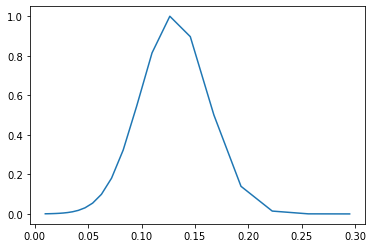

In [41]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.plot(np.logspace(-2, 1, num=50).flatten()[:25], f0r[:25])

In [62]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(0.000687265)),
 (1, 0.011513953993264475, DM(0.000824485)),
 (2, 0.013257113655901088, DM(0.00101386)),
 (3, 0.015264179671752334, DM(0.00128152)),
 (4, 0.017575106248547922, DM(0.00166997)),
 (5, 0.020235896477251575, DM(0.0022502)),
 (6, 0.023299518105153717, DM(0.00314428)),
 (7, 0.02682695795279726, DM(0.00456833)),
 (8, 0.030888435964774818, DM(0.00691581)),
 (9, 0.03556480306223128, DM(0.0109217)),
 (10, 0.040949150623804255, DM(0.0179877)),
 (11, 0.04714866363457394, DM(0.0308185)),
 (12, 0.054286754393238594, DM(0.0546118)),
 (13, 0.06250551925273973, DM(0.0990481)),
 (14, 0.07196856730011521, DM(0.180732)),
 (15, 0.08286427728546843, DM(0.323105)),
 (16, 0.09540954763499938, DM(0.544038)),
 (17, 0.10985411419875583, DM(0.81472)),
 (18, 0.12648552168552957, DM(1)),
 (19, 0.14563484775012436, DM(0.896814)),
 (20, 0.16768329368110083, DM(0.500799)),
 (21, 0.19306977288832497, DM(0.139643)),
 (22, 0.22229964825261944, DM(0.0143658)),
 (23, 0.2559547922699536, DM(0.00

In [68]:
a0 = linterp(0.06250551925273973, 0.07196856730011521, 0.0990481, 0.180732, 0.15)
a1 = linterp(0.16768329368110083, 0.19306977288832497, 0.500799, 0.139643,  0.15)
a0idx = [13, 14]
a1idx = [20, 21]

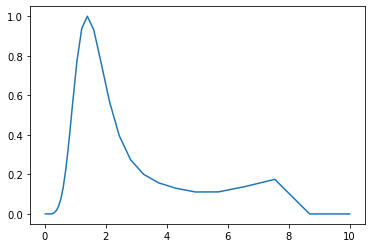

In [42]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.plot(np.logspace(-2, 1, num=50).flatten(), f1r)

In [63]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(5.13443e-24)),
 (1, 0.011513953993264475, DM(1.72058e-23)),
 (2, 0.013257113655901088, DM(6.85053e-23)),
 (3, 0.015264179671752334, DM(3.3001e-22)),
 (4, 0.017575106248547922, DM(1.95573e-21)),
 (5, 0.020235896477251575, DM(1.44261e-20)),
 (6, 0.023299518105153717, DM(1.33539e-19)),
 (7, 0.02682695795279726, DM(1.54243e-18)),
 (8, 0.030888435964774818, DM(2.18481e-17)),
 (9, 0.03556480306223128, DM(3.67278e-16)),
 (10, 0.040949150623804255, DM(6.94298e-15)),
 (11, 0.04714866363457394, DM(1.37771e-13)),
 (12, 0.054286754393238594, DM(2.64829e-12)),
 (13, 0.06250551925273973, DM(4.51542e-11)),
 (14, 0.07196856730011521, DM(6.26917e-10)),
 (15, 0.08286427728546843, DM(6.58178e-09)),
 (16, 0.09540954763499938, DM(4.91778e-08)),
 (17, 0.10985411419875583, DM(2.50014e-07)),
 (18, 0.12648552168552957, DM(1.08863e-06)),
 (19, 0.14563484775012436, DM(5.14416e-06)),
 (20, 0.16768329368110083, DM(2.53801e-05)),
 (21, 0.19306977288832497, DM(0.000121513)),
 (22, 0.22229964825261944, 

In [69]:
b0 = linterp(0.5963623316594643, 0.6866488450043002, 0.132519, 0.228639, 0.15)
b1 = linterp(4.291934260128778, 3.727593720314938, 0.129938, 0.157323, 0.15)
b0idx = [29, 30]
b1idx = [42, 43]

In [70]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[8.957723286562654, 3.185904246428885, 56.69640751555968, 20.164646716877655]

In [79]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [81]:
def rinf(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinf(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[6204.216371839589, 5952.932693238474, 4688.560249784527, 4737.958309373741]

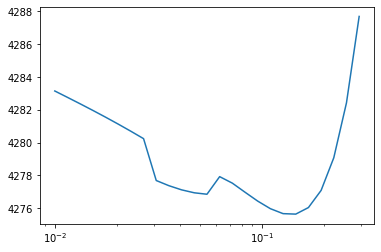

In [35]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [121]:
from scipy.integrate import solve_ivp
print(model.observation_times[75])
sol = solve_ivp(lambda t,y: seir(t, y, getp(sols[idx]['x'])), [0, 60], [getx(sols[idx]['x'])[i][75] for i in range(4)], dense_output=True)

77.69696969696969


In [122]:
model.observation_times[-1]

92.0

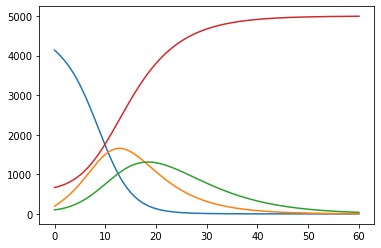

In [123]:
tfine = np.linspace(0, 60, 600)
plt.plot(tfine, sol.sol(tfine).T)

In [124]:
rfin = sol.sol(tfine)[-1,-1]

In [130]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [131]:
tfine[ridx]

31.853088480801336

In [132]:
tfine[ridx]-(92-model.observation_times[75])

17.550058177771025

In [129]:
92-model.observation_times[75]

14.303030303030312

In [133]:
historical_mortality = 0.02
current_mortality = 39/2936
print(historical_mortality, current_mortality)

0.02 0.013283378746594006


In [136]:
rfin*historical_mortality

99.86000968324464

In [135]:
rfin*current_mortality

66.32391651305417